In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
from sentence_transformers import SentenceTransformer, util
from InstructorEmbedding import INSTRUCTOR
from transformers import AutoModel
import torch

In [48]:
""" module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url) """

roberta_model = SentenceTransformer('stsb-roberta-large')
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
distilbert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
#instructor_model = INSTRUCTOR('hkunlp/instructor-large') #instructor-large
""" anita_model = "DeepMount00/Anita"
labse_model = "LaBSE" """
""" e5_model = SentenceTransformer('intfloat/e5-large-v2') """
t5_model = SentenceTransformer('sentence-transformers/sentence-t5-xl')
#distilbert_modelv2 = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

In [49]:
# Process for Question 1
df_q1 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-1')

# Assuming answers are in the third column
answers_q1 = df_q1.iloc[:, 1].fillna('').tolist()
scores_q1 = df_q1.iloc[:, 2].fillna(0).tolist()
#query_q1 = 'The Arabs made significant contributions to mathematics, astronomy, medicine, chemistry, and engineering. Notably, the development of algebra and algorithms, the optical works of Ibn al-Haytham, the medical encyclopedia "The Canon of Medicine" by Avicenna, and the contributions to trigonometry by Abū al-Wafā\' are foundational. Additionally, the mathematical and astronomical works of Al-Khwarizmi are cornerstone contributions, highlighting the Arabs\' role in shaping modern science.'

print(answers_q1)


query_q1 = "Arab contributions to science include groundbreaking work in optics, the development of algebra and algorithms, advancements in cartography and navigation, the translation and preservation of ancient knowledge, and significant discoveries in medicine and surgery."

# ST modeli ile vektörleri hesapla
roberta_vectors = roberta_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
roberta_query_vector = roberta_vectors[-1]
roberta_cosine_similarities = util.pytorch_cos_sim(roberta_vectors[:-1], roberta_query_vector)

# ST modeli 2 ile vektörleri hesapla ama orijinal score değeri 0 olanların içinde cevap boş ise skor 0 olacak
bert_vectors = bert_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
bert_query_vector = bert_vectors[-1]
bert_cosine_similarities = util.pytorch_cos_sim(bert_vectors[:-1], bert_query_vector)




# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors = distilbert_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
distilbert_query_vector = distilbert_vectors[-1]
distilbert_cosine_similarities = util.pytorch_cos_sim(distilbert_vectors[:-1], distilbert_query_vector)


# T5 modeli ile vektörleri hesapla
t5_vectors = t5_model.encode(answers_q1 + [query_q1], convert_to_tensor=True)
t5_query_vector = t5_vectors[-1]
t5_cosine_similarities = util.pytorch_cos_sim(t5_vectors[:-1], t5_query_vector)

# Öğrenci cevaplarının boş olup olmadığını kontrol etmek için bir fonksiyon
def check_if_answer_is_empty(answer):
    # Cevap eğer boş bir string veya sadece boşluklardan oluşuyorsa True döner
    return answer.strip() == ""


# Cevapların boş olup olmadığını kontrol et ve bir mask oluştur
empty_answer_mask = [check_if_answer_is_empty(answer) for answer in answers_q1]
# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
#zero_score_mask = torch.tensor(scores_q1) == 0

# Bu maski kullanarak, ilgili skorlar cevapları da boş ise sıfıra ayarla
""" def adjust_scores_for_zero(cosine_similarities, mask):
    adjusted_scores = cosine_similarities.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores """

# Cosine benzerlik skorlarını hesapla ve boş cevaplar için skorları ayarla
def adjust_scores(cosine_similarities, empty_mask):
    adjusted_scores = cosine_similarities.clone().detach()  # Tensörü klonla ve detach yap
    for i, is_empty in enumerate(empty_mask):
        if is_empty:  # Eğer cevap boşsa
            adjusted_scores[i] = 0  # İlgili skoru sıfıra ayarla
    return adjusted_scores
# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities = adjust_scores(roberta_cosine_similarities, empty_answer_mask)
bert_cosine_similarities = adjust_scores(bert_cosine_similarities, empty_answer_mask)
distilbert_cosine_similarities = adjust_scores(distilbert_cosine_similarities, empty_answer_mask)
""" distilbert_cosine_similaritiesv2 = adjust_scores(distilbert_cosine_similaritiesv2, empty_answer_mask)
instructor_cosine_similarities = adjust_scores(instructor_cosine_similarities, empty_answer_mask) """
t5_cosine_similarities = adjust_scores(t5_cosine_similarities, empty_answer_mask)


df_q1['Roberta Score'] = np.round(roberta_cosine_similarities.cpu().numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['Bert Score'] = np.round(bert_cosine_similarities.cpu().numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['DistilBert Score'] = np.round(distilbert_cosine_similarities.cpu().numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
""" df_q1['Anita Score'] = np.round(anita_cosine_similarities.cpu().numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['LaBSE Score'] = np.round(labse_cosine_similarities.cpu().numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak """
#df_q1['E5 Score'] = np.round(e5_cosine_similarities.cpu().numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
""" df_q1['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv2.cpu().numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak
df_q1['Instructor Score'] = np.round(instructor_cosine_similarities.cpu().numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak """
df_q1['T5 Score'] = np.round(t5_cosine_similarities.cpu().numpy().flatten()*20).astype(int) # ST skoru, tamsayı olarak

# İlk birkaç satırı göster
df_q1.head()

['arabs contributed important concepts like optics surgery quarantine prevent spread diseases algebra algorithm invented paper enabled punishments house wisdom baghdad speak algorithm al - khwarizmi easily accepted father algorithm word derived word quit algebra quit latin term', 'ali ku credit u proved astronomical facts evidence allowing astronomy separated religion books medicine improved eye ear throat surgeries ibn sina wrote book medicine piri reis drew world map combination maps creating world map', 'estimate number days year geography need know makea time', 'samarkand school geography astronomy provided primary sources ottoman s knowledge geography map - making related fields p d ispasted emp brief liquor learn knowledge china basis promoted science invested progress arabs arabs developed algebra alchemy algorithm average almanac aorta alcohol arabic origin words finding direction mecca pray time required accurate measurement time location sphere shape earth dash establishment 

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,T5 Score
0,20190808014,arabs contributed important concepts like opti...,20,12,12,13,18
1,20190808021,ali ku credit u proved astronomical facts evid...,8,10,13,13,16
2,20190808035,estimate number days year geography need know ...,4,3,6,4,12
3,20200808003,samarkand school geography astronomy provided ...,14,11,13,14,17
4,20200808008,glass optics omar khayyam described laws refle...,18,9,9,10,16


In [50]:
# Process for Question 1
df_q2 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-2')

# Assuming answers are in the third column
answers_q2 = df_q2.iloc[:, 1].fillna('').tolist()
scores_q2 = df_q2.iloc[:, 2].fillna(0).tolist()

print(answers_q2)


query_q2 = "The Roman Empire's contributions to the legal system include the development of the Twelve Tables, which laid the foundation for Roman law, influencing modern legal systems with concepts of democracy, division of power, legal rights in trade and conflict, and the basis for evidence and proof in judicial proceedings."

# ST modeli ile vektörleri hesapla
roberta_vectors2 = roberta_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
roberta_query_vector2 = roberta_vectors2[-1]
roberta_cosine_similarities2 = util.pytorch_cos_sim(roberta_vectors2[:-1], roberta_query_vector2)

# ST modeli 2 ile vektörleri hesapla
bert_vectors2 = bert_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
bert_query_vector2 = bert_vectors2[-1]
bert_cosine_similarities2 = util.pytorch_cos_sim(bert_vectors2[:-1], bert_query_vector2)

# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors2 = distilbert_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
distilbert_query_vector2 = distilbert_vectors2[-1]
distilbert_cosine_similarities2 = util.pytorch_cos_sim(distilbert_vectors2[:-1], distilbert_query_vector2)

""" # DistilBERT modeli v2 ile vektörleri hesapla
distilbert_vectorsv2 = distilbert_modelv2.encode(answers_q2 + [query_q2], convert_to_tensor=True)
distilbert_query_vectorv22 = distilbert_vectorsv2[-1]
distilbert_cosine_similaritiesv22 = util.pytorch_cos_sim(distilbert_vectorsv2[:-1], distilbert_query_vectorv2)

# Instructor modeli ile vektörleri hesapla
instructor_vectors2 = instructor_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
instructor_query_vector2 = instructor_vectors2[-1]
instructor_cosine_similarities2 = util.pytorch_cos_sim(instructor_vectors2[:-1], instructor_query_vector2) """

""" # Anita modeli ile vektörleri hesapla
anita_vectors2 = roberta_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
anita_query_vector2 = anita_vectors2[-1]
anita_cosine_similarities2 = util.pytorch_cos_sim(anita_vectors2[:-1], anita_query_vector2)

# LaBSE modeli ile vektörleri hesapla
labse_vectors2 = roberta_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
labse_query_vector2 = labse_vectors2[-1]
labse_cosine_similarities2 = util.pytorch_cos_sim(labse_vectors2[:-1], labse_query_vector2) """

""" # E5 modeli ile vektörleri hesapla
e5_vectors2 = e5_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
e5_query_vector2 = e5_vectors2[-1]
e5_cosine_similarities2 = util.pytorch_cos_sim(e5_vectors2[:-1], e5_query_vector2) """

# T5 modeli ile vektörleri hesapla
t5_vectors2 = t5_model.encode(answers_q2 + [query_q2], convert_to_tensor=True)
t5_query_vector2 = t5_vectors2[-1]
t5_cosine_similarities2 = util.pytorch_cos_sim(t5_vectors2[:-1], t5_query_vector2)

# Cevapların boş olup olmadığını kontrol et ve bir mask oluştur
empty_answer_mask = [check_if_answer_is_empty(answer) for answer in answers_q1]
# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
#zero_score_mask = torch.tensor(scores_q1) == 0

# Bu maski kullanarak, ilgili skorlar cevapları da boş ise sıfıra ayarla
""" def adjust_scores_for_zero(cosine_similarities, mask):
    adjusted_scores = cosine_similarities.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores """

# Cosine benzerlik skorlarını hesapla ve boş cevaplar için skorları ayarla
def adjust_scores(cosine_similarities, empty_mask):
    adjusted_scores = cosine_similarities.clone().detach()  # Tensörü klonla ve detach yap
    for i, is_empty in enumerate(empty_mask):
        if is_empty:  # Eğer cevap boşsa
            adjusted_scores[i] = 0  # İlgili skoru sıfıra ayarla
    return adjusted_scores
# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities2 = adjust_scores(roberta_cosine_similarities2, empty_answer_mask)
bert_cosine_similarities2 = adjust_scores(bert_cosine_similarities2, empty_answer_mask)
distilbert_cosine_similarities2 = adjust_scores(distilbert_cosine_similarities2, empty_answer_mask)
""" distilbert_cosine_similaritiesv22 = adjust_scores(distilbert_cosine_similaritiesv22, empty_answer_mask)
instructor_cosine_similarities2 = adjust_scores(instructor_cosine_similarities2, empty_answer_mask) """
""" anita_cosine_similarities = adjust_scores(anita_cosine_similarities, empty_answer_mask)
labse_cosine_similarities = adjust_scores(labse_cosine_similarities, empty_answer_mask) """
#e5_cosine_similarities = adjust_scores(e5_cosine_similarities, empty_answer_mask)
t5_cosine_similarities2 = adjust_scores(t5_cosine_similarities2, empty_answer_mask)

# Notları hesapla ve DataFrame'e ekle
#df_q1['USE Score'] = np.round(use_cosine_similarities * 20).astype(int)  # USE skoru, tamsayı olarak
df_q2['Roberta Score'] = np.round(roberta_cosine_similarities2.cpu().numpy().flatten() * 20).astype(int)  # ST skoru, tamsayı olarak
df_q2['Bert Score'] = np.round(bert_cosine_similarities2.cpu().numpy().flatten() * 20).astype(int)  # ST2 skoru, tamsayı olarak
df_q2['DistilBert Score'] = np.round(distilbert_cosine_similarities2.cpu().numpy().flatten() * 20).astype(int)  # DistilBERT skoru, tamsayı olarak
""" df_q2['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv2.cpu().numpy().flatten() * 20).astype(int)  # DistilBERT V2 skoru, tamsayı olarak
df_q2['Instructor Score'] = np.round(instructor_cosine_similarities2.cpu().numpy().flatten() * 20).astype(int)  # Instructor skoru, tamsayı olarak """
""" df_q2['Anita Score'] = np.round(anita_cosine_similarities2.cpu().numpy().flatten() * 20).astype(int)  # Anita skoru, tamsayı olarak
df_q2['LaBSE Score'] = np.round(labse_cosine_similarities2.cpu().numpy().flatten() * 20).astype(int)  # LaBSE skoru, tamsayı olarak """
#df_q2['E5 Score'] = np.round(e5_cosine_similarities2.cpu().numpy().flatten() * 20).astype(int)  # E5 skoru, tamsayı olarak
df_q2['T5 Score'] = np.round(t5_cosine_similarities2.cpu().numpy().flatten() * 20).astype(int)  # T5 skoru, tamsayı olarak


# İlk birkaç satırı göster
df_q2.head()

['introduce calendars calculate days 1 year 12 tables rule empire', 'introduce laws apply laws units like consuls assemblies senate law s 12 tables', 'checks balances vetoes separation powers term limits', 'introduced twelve tables guilty proven guilty prisons firstly equal ruler', '', 'lawyer jury juries prison', 'twelve tables rome', 'government closed consulates senate assemblies', 'lawyer improved laws way works society introduced lawyer jury system', 'revolt plebs modern judgment system like today 12 tables system 2 consuls 1 assembly 1 senate 2 consuls makes wrong decision reject decision', 'introduced modern legal concepts assemblies sent conceals distribution power important arrested innocent proofing guilty', 'introduce 12 table law introduce council prison introduce compass roads highways', 'early civilizations ruled kings priests laws punishments following laws corpus juries included modern legal concepts liquor accused innocent proven guilty duo judgment punishments based p

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,T5 Score
0,20210808035,introduce calendars calculate days 1 year 12 t...,8,9,11,12,16
1,20220808013,introduce laws apply laws units like consuls a...,8,11,15,15,16
2,20220808706,checks balances vetoes separation powers term ...,0,4,7,6,13
3,20220808063,introduced twelve tables guilty proven guilty ...,14,9,11,11,16
4,20220808019,NaN,0,1,0,1,12


In [51]:
# Process for Question 3
df_q3 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-3')

# Assuming answers are in the third column
answers_q3 = df_q3.iloc[:, 1].fillna('').tolist()
scores_q3 = df_q3.iloc[:, 2].fillna(0).tolist()

print(answers_q3)

query_q3 = 'In Medieval Europe, education played a crucial role in developing the legal system, particularly in establishing the principles of proving innocence or guilt, the use of juries and trials for judicial processes, and the reliance on precedents and legal expertise, drawing from earlier foundations like the Twelve Tables.'
# ST modeli ile vektörleri hesapla
roberta_vectors3 = roberta_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
roberta_query_vector3 = roberta_vectors3[-1]
roberta_cosine_similarities3 = util.pytorch_cos_sim(roberta_vectors3[:-1], roberta_query_vector3)

# ST modeli 2 ile vektörleri hesapla
bert_vectors3 = bert_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
bert_query_vector3 = bert_vectors3[-1]
bert_cosine_similarities3 = util.pytorch_cos_sim(bert_vectors3[:-1], bert_query_vector3)

# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors3 = distilbert_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
distilbert_query_vector3 = distilbert_vectors3[-1]
distilbert_cosine_similarities3 = util.pytorch_cos_sim(distilbert_vectors3[:-1], distilbert_query_vector3)

""" # DistilBERT modeli v2 ile vektörleri hesapla
distilbert_vectorsv3 = distilbert_modelv2.encode(answers_q3 + [query_q3], convert_to_tensor=True)
distilbert_query_vectorv23 = distilbert_vectorsv3[-1]
distilbert_cosine_similaritiesv3 = util.pytorch_cos_sim(distilbert_vectorsv3[:-1], distilbert_query_vectorv23) """

""" # Instructor modeli ile vektörleri hesapla
instructor_vectors3 = instructor_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
instructor_query_vector3 = instructor_vectors3[-1]
instructor_cosine_similarities3 = util.pytorch_cos_sim(instructor_vectors3[:-1], instructor_query_vector3) """

""" # Anita modeli ile vektörleri hesapla
anita_vectors3 = roberta_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
anita_query_vector3 = anita_vectors3[-1]
anita_cosine_similarities3 = util.pytorch_cos_sim(anita_vectors3[:-1], anita_query_vector3)

# LaBSE modeli ile vektörleri hesapla
labse_vectors3 = roberta_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
labse_query_vector3 = labse_vectors3[-1]
labse_cosine_similarities3 = util.pytorch_cos_sim(labse_vectors3[:-1], labse_query_vector3) """

""" # E5 modeli ile vektörleri hesapla
e5_vectors3 = e5_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
e5_query_vector3 = e5_vectors3[-1]
e5_cosine_similarities3 = util.pytorch_cos_sim(e5_vectors3[:-1], e5_query_vector3) """

# T5 modeli ile vektörleri hesapla
t5_vectors3 = t5_model.encode(answers_q3 + [query_q3], convert_to_tensor=True)
t5_query_vector3 = t5_vectors3[-1]
t5_cosine_similarities3 = util.pytorch_cos_sim(t5_vectors3[:-1], t5_query_vector3)

# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
zero_score_mask3 = torch.tensor(scores_q3) == 0

# Bu maski kullanarak, ilgili skorları sıfıra ayarla
def adjust_scores_for_zero(cosine_similarities3, mask):
    adjusted_scores3 = cosine_similarities3.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores3[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores3

# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities3 = adjust_scores_for_zero(roberta_cosine_similarities3, zero_score_mask3)
bert_cosine_similarities3 = adjust_scores_for_zero(bert_cosine_similarities3, zero_score_mask3)
distilbert_cosine_similarities3 = adjust_scores_for_zero(distilbert_cosine_similarities3, zero_score_mask3)
""" distilbert_cosine_similaritiesv3 = adjust_scores_for_zero(distilbert_cosine_similaritiesv3, zero_score_mask3)
instructor_cosine_similarities3 = adjust_scores_for_zero(instructor_cosine_similarities3, zero_score_mask3) """
""" anita_cosine_similarities3 = adjust_scores_for_zero(anita_cosine_similarities3, zero_score_mask3)
labse_cosine_similarities3 = adjust_scores_for_zero(labse_cosine_similarities3, zero_score_mask3) """
#e5_cosine_similarities3 = adjust_scores_for_zero(e5_cosine_similarities3, zero_score_mask3)
t5_cosine_similarities3 = adjust_scores_for_zero(t5_cosine_similarities3, zero_score_mask3)

# Notları hesapla ve DataFrame'e ekle
#df_q1['USE Score'] = np.round(use_cosine_similarities * 20).astype(int)  # USE skoru, tamsayı olarak
df_q3['Roberta Score'] = np.round(roberta_cosine_similarities3.cpu().numpy().flatten() * 20).astype(int)  # ST skoru, tamsayı olarak
df_q3['Bert Score'] = np.round(bert_cosine_similarities3.cpu().numpy().flatten() * 20).astype(int)  # ST2 skoru, tamsayı olarak
df_q3['DistilBert Score'] = np.round(distilbert_cosine_similarities3.cpu().numpy().flatten() * 20).astype(int)  # DistilBERT skoru, tamsayı olarak
""" df_q3['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv3.cpu().numpy().flatten() * 20).astype(int)  # DistilBERT V2 skoru, tamsayı olarak
df_q3['Instructor Score'] = np.round(instructor_cosine_similarities3.cpu().numpy().flatten() * 20).astype(int)  # Instructor skoru, tamsayı olarak """
""" df_q3['Anita Score'] = np.round(anita_cosine_similarities3.cpu().numpy().flatten() * 20).astype(int)  # Anita skoru, tamsayı olarak
df_q3['LaBSE Score'] = np.round(labse_cosine_similarities3.cpu().numpy().flatten() * 20).astype(int)  # LaBSE skoru, tamsayı olarak """
#df_q3['E5 Score'] = np.round(e5_cosine_similarities3.cpu().numpy().flatten() * 20).astype(int)  # E5 skoru, tamsayı olarak
df_q3['T5 Score'] = np.round(t5_cosine_similarities3.cpu().numpy().flatten() * 20).astype(int)  # T5 skoru, tamsayı olarak


# İlk birkaç satırı göster
df_q3.head()

['advanced modern legal system civil engineering military engineering like gregorian calendar divided powers known division powers 3 parties consuls senate assemblies mention conflict interests example senators forbidden trade influences gains trading terms theaters having great open - air settings tales gods love etc romanian theater stories closed realistic shows acted makes theater influence democracy', 'main battlefield surgeries bound books 12 tables julian calendar aqueducts roman bridges roads highways newspapers welfare concrete working mathematical philosophical astronomical improvements worked military building law improvements thinker builder', 'roads highways geometry military engineering science changes life', '', 'achieved civil army engineering republic government system fundamentals modern legal systems road trade web europe rule medittarenean hundreds years seeking answers questions nature developing theories philosophies developed science philosophy improved tools arm

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,T5 Score
0,20190808014,advanced modern legal system civil engineering...,17,3,9,8,15
1,20190808021,main battlefield surgeries bound books 12 tabl...,18,9,10,10,15
2,20190808035,roads highways geometry military engineering s...,11,4,9,9,13
3,20200808003,NaN,0,0,0,0,0
4,20200808008,achieved civil army engineering republic gover...,17,9,12,11,15


In [52]:
# Process for Question 2
df_q4 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-4')

# Assuming answers are in the third column
answers_q4 = df_q4.iloc[:, 1].fillna('').tolist()
scores_q4 = df_q4.iloc[:, 2].fillna(0).tolist()

print(answers_q4)

query_q4 = 'The impacts of the Industrial Revolution on society were profound and multifaceted, including significant advancements in engineering and technology, akin to the discoveries in geometry by Euclid, Thales, and Pythagoras, which transformed understanding through the study of shadows, angles, and perimeters, and innovations in scientific thought and projects that paralleled the astronomical observations and mathematical deductions of ancient scholars.'
# ST modeli ile vektörleri hesapla
roberta_vectors4 = roberta_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
roberta_query_vector4 = roberta_vectors4[-1]
roberta_cosine_similarities4 = util.pytorch_cos_sim(roberta_vectors4[:-1], roberta_query_vector4)

# ST modeli 2 ile vektörleri hesapla
bert_vectors4 = bert_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
bert_query_vector4 = bert_vectors4[-1]
bert_cosine_similarities4 = util.pytorch_cos_sim(bert_vectors4[:-1], bert_query_vector4)

# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors4 = distilbert_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
distilbert_query_vector4 = distilbert_vectors4[-1]
distilbert_cosine_similarities4 = util.pytorch_cos_sim(distilbert_vectors4[:-1], distilbert_query_vector4)

""" # DistilBERT modeli v2 ile vektörleri hesapla
distilbert_vectorsv4 = distilbert_modelv2.encode(answers_q4 + [query_q4], convert_to_tensor=True)
distilbert_query_vectorv24 = distilbert_vectorsv4[-1]
distilbert_cosine_similaritiesv4 = util.pytorch_cos_sim(distilbert_vectorsv4[:-1], distilbert_query_vectorv24)

# Instructor modeli ile vektörleri hesapla
instructor_vectors4 = instructor_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
instructor_query_vector4 = instructor_vectors4[-1]
instructor_cosine_similarities4 = util.pytorch_cos_sim(instructor_vectors4[:-1], instructor_query_vector4) """

""" # Anita modeli ile vektörleri hesapla
anita_vectors4 = roberta_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
anita_query_vector4 = anita_vectors4[-1]
anita_cosine_similarities4 = util.pytorch_cos_sim(anita_vectors4[:-1], anita_query_vector4)

# LaBSE modeli ile vektörleri hesapla
labse_vectors4 = roberta_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
labse_query_vector4 = labse_vectors4[-1]
labse_cosine_similarities4 = util.pytorch_cos_sim(labse_vectors4[:-1], labse_query_vector4) """

""" # E5 modeli ile vektörleri hesapla
e5_vectors4 = e5_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
e5_query_vector4 = e5_vectors4[-1]
e5_cosine_similarities4 = util.pytorch_cos_sim(e5_vectors4[:-1], e5_query_vector4) """

# T5 modeli ile vektörleri hesapla
t5_vectors4 = t5_model.encode(answers_q4 + [query_q4], convert_to_tensor=True)
t5_query_vector4 = t5_vectors4[-1]
t5_cosine_similarities4 = util.pytorch_cos_sim(t5_vectors4[:-1], t5_query_vector4)


# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
zero_score_mask4 = torch.tensor(scores_q4) == 0

# Bu maski kullanarak, ilgili skorları sıfıra ayarla
def adjust_scores_for_zero(cosine_similarities4, mask):
    adjusted_scores4 = cosine_similarities4.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores4[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores4

# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities4 = adjust_scores_for_zero(roberta_cosine_similarities4, zero_score_mask4)
bert_cosine_similarities4 = adjust_scores_for_zero(bert_cosine_similarities4, zero_score_mask4)
distilbert_cosine_similarities4 = adjust_scores_for_zero(distilbert_cosine_similarities4, zero_score_mask4)
""" distilbert_cosine_similaritiesv4 = adjust_scores_for_zero(distilbert_cosine_similaritiesv4, zero_score_mask4)
instructor_cosine_similarities4 = adjust_scores_for_zero(instructor_cosine_similarities4, zero_score_mask4) """
""" anita_cosine_similarities4 = adjust_scores_for_zero(anita_cosine_similarities4, zero_score_mask4)
labse_cosine_similarities4 = adjust_scores_for_zero(labse_cosine_similarities4, zero_score_mask4)
e5_cosine_similarities4 = adjust_scores_for_zero(e5_cosine_similarities4, zero_score_mask4) """
t5_cosine_similarities4 = adjust_scores_for_zero(t5_cosine_similarities4, zero_score_mask4)

# Notları hesapla ve DataFrame'e ekle
#df_q1['USE Score'] = np.round(use_cosine_similarities * 20).astype(int)  # USE skoru, tamsayı olarak
df_q4['Roberta Score'] = np.round(roberta_cosine_similarities4.cpu().numpy().flatten() * 20).astype(int)  # ST skoru, tamsayı olarak
df_q4['Bert Score'] = np.round(bert_cosine_similarities4.cpu().numpy().flatten() * 20).astype(int)  # ST2 skoru, tamsayı olarak
df_q4['DistilBert Score'] = np.round(distilbert_cosine_similarities4.cpu().numpy().flatten() * 20).astype(int)  # DistilBERT skoru, tamsayı olarak
""" df_q4['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv4.cpu().numpy().flatten() * 20).astype(int)  # DistilBERT V2 skoru, tamsayı olarak
df_q4['Instructor Score'] = np.round(instructor_cosine_similarities4.cpu().numpy().flatten() * 20).astype(int)  # Instructor skoru, tamsayı olarak """
""" df_q4['Anita Score'] = np.round(anita_cosine_similarities4.cpu().numpy().flatten() * 20).astype(int)  # Anita skoru, tamsayı olarak
df_q4['LaBSE Score'] = np.round(labse_cosine_similarities4.cpu().numpy().flatten() * 20).astype(int)  # LaBSE skoru, tamsayı olarak
df_q4['E5 Score'] = np.round(e5_cosine_similarities4.cpu().numpy().flatten() * 20).astype(int)  # E5 skoru, tamsayı olarak """
df_q4['T5 Score'] = np.round(t5_cosine_similarities4.cpu().numpy().flatten() * 20).astype(int)  # T5 skoru, tamsayı olarak



# İlk birkaç satırı göster
df_q4.head()

['aristarchus knew earths size clever application geometry deduced size earths shadow distance moon cumulativeness science', 'diameter earth known diameter moon calculated circles angles shadows moon falling earth solar eclipses diameter earth diameter moon distance earth moon calculated lunar eclipse moon stayed lunar eclipse created shadow worth 2 5 moons diameter earth calculations distance calculated', 'find height moon lunar solar eclipse calculate height thing calculate distance thing center earth', '', 'aristarchus knows size earth calculate size earths shadow moon thales intercept theorem calculate distance earth moon', '', 'observe earth moons motions earths shadow predict calculate geometry aristarchus predict moons earths weight', 'thales theorems know coin perimeter perimeter earth calculating distance earth moon ratio coin perimeter shadow earth moon point ratio coin earth perimeter equals dot earth moon mean distance', '- finding moon diameter earth diameter hypothesis ar

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,T5 Score
0,20190808014,aristarchus knew earths size clever applicatio...,8,12,12,12,13
1,20190808021,diameter earth known diameter moon calculated ...,16,9,7,9,13
2,20190808035,find height moon lunar solar eclipse calculate...,8,10,8,9,13
3,20200808003,NaN,0,0,0,0,0
4,20200808008,aristarchus knows size earth calculate size ea...,16,11,9,9,13


In [53]:
# Process for Question 2
df_q5 = pd.read_excel('new_processed-answers.xlsx', sheet_name='Q-5')

# Assuming answers are in the third column
answers_q5 = df_q5.iloc[:, 1].fillna('').tolist()
scores_q5 = df_q5.iloc[:, 2].fillna(0).tolist()

print(answers_q5)

query_q5 = 'According to Aristotle, if a hypothesis leads to a contradiction, it must be rejected as false. This method, known as reductio ad absurdum (proof by contradiction), is used in logic to demonstrate the invalidity of an assumption by showing that it results in an impossible or contradictory outcome.'
# ST modeli ile vektörleri hesapla
roberta_vectors5 = roberta_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
roberta_query_vector5 = roberta_vectors5[-1]
roberta_cosine_similarities5 = util.pytorch_cos_sim(roberta_vectors5[:-1], roberta_query_vector5)

# ST modeli 2 ile vektörleri hesapla
bert_vectors5 = bert_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
bert_query_vector5 = bert_vectors5[-1]
bert_cosine_similarities5 = util.pytorch_cos_sim(bert_vectors5[:-1], bert_query_vector5)

# DistilBERT modeli ile vektörleri hesapla
distilbert_vectors5 = distilbert_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
distilbert_query_vector5 = distilbert_vectors5[-1]
distilbert_cosine_similarities5 = util.pytorch_cos_sim(distilbert_vectors5[:-1], distilbert_query_vector5)

""" # DistilBERT modeli v2 ile vektörleri hesapla
distilbert_vectorsv5 = distilbert_modelv2.encode(answers_q5 + [query_q5], convert_to_tensor=True)
distilbert_query_vectorv25 = distilbert_vectorsv5[-1]
distilbert_cosine_similaritiesv5 = util.pytorch_cos_sim(distilbert_vectorsv5[:-1], distilbert_query_vectorv25)

# Instructor modeli ile vektörleri hesapla
instructor_vectors5 = instructor_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
instructor_query_vector5 = instructor_vectors5[-1]
instructor_cosine_similarities5 = util.pytorch_cos_sim(instructor_vectors5[:-1], instructor_query_vector5) """

""" # Anita modeli ile vektörleri hesapla
anita_vectors5 = roberta_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
anita_query_vector5 = anita_vectors5[-1]
anita_cosine_similarities5 = util.pytorch_cos_sim(anita_vectors5[:-1], anita_query_vector5) """

""" # LaBSE modeli ile vektörleri hesapla
labse_vectors5 = roberta_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
labse_query_vector5 = labse_vectors5[-1]
labse_cosine_similarities5 = util.pytorch_cos_sim(labse_vectors5[:-1], labse_query_vector5) """

""" # E5 modeli ile vektörleri hesapla
e5_vectors5 = e5_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
e5_query_vector5 = e5_vectors5[-1]
e5_cosine_similarities5 = util.pytorch_cos_sim(e5_vectors5[:-1], e5_query_vector5) """

# T5 modeli ile vektörleri hesapla
t5_vectors5 = t5_model.encode(answers_q5 + [query_q5], convert_to_tensor=True)
t5_query_vector5 = t5_vectors5[-1]
t5_cosine_similarities5 = util.pytorch_cos_sim(t5_vectors5[:-1], t5_query_vector5)

# Score değeri 0 olan cevapların indekslerini bir PyTorch maskesi olarak oluştur
zero_score_mask5 = torch.tensor(scores_q5) == 0

# Bu maski kullanarak, ilgili skorları sıfıra ayarla
def adjust_scores_for_zero(cosine_similarities5, mask):
    adjusted_scores5 = cosine_similarities5.clone()  # Orjinal tensörü değiştirmemek için klonla
    adjusted_scores5[mask] = 0  # Mask ile belirtilen indekslerdeki değerleri sıfırla
    return adjusted_scores5

# Şimdi, her bir model için bu fonksiyonu kullanarak skorları ayarlayın
roberta_cosine_similarities5 = adjust_scores_for_zero(roberta_cosine_similarities5, zero_score_mask5)
bert_cosine_similarities5 = adjust_scores_for_zero(bert_cosine_similarities5, zero_score_mask5)
distilbert_cosine_similarities5 = adjust_scores_for_zero(distilbert_cosine_similarities5, zero_score_mask5)
""" distilbert_cosine_similaritiesv5 = adjust_scores_for_zero(distilbert_cosine_similaritiesv5, zero_score_mask5)
instructor_cosine_similarities5 = adjust_scores_for_zero(instructor_cosine_similarities5, zero_score_mask5) """
""" anita_cosine_similarities5 = adjust_scores_for_zero(anita_cosine_similarities5, zero_score_mask5)
labse_cosine_similarities5 = adjust_scores_for_zero(labse_cosine_similarities5, zero_score_mask5)
e5_cosine_similarities5 = adjust_scores_for_zero(e5_cosine_similarities5, zero_score_mask5) """
t5_cosine_similarities5 = adjust_scores_for_zero(t5_cosine_similarities5, zero_score_mask5)

# Notları hesapla ve DataFrame'e ekle
#df_q1['USE Score'] = np.round(use_cosine_similarities * 20).astype(int)  # USE skoru, tamsayı olarak
df_q5['Roberta Score'] = np.round(roberta_cosine_similarities5.cpu().numpy().flatten() * 20).astype(int)  # ST skoru, tamsayı olarak
df_q5['Bert Score'] = np.round(bert_cosine_similarities5.cpu().numpy().flatten() * 20).astype(int)  # ST2 skoru, tamsayı olarak
df_q5['DistilBert Score'] = np.round(distilbert_cosine_similarities5.cpu().numpy().flatten() * 20).astype(int)  # DistilBERT skoru, tamsayı olarak
""" df_q5['DistilBert Score v2'] = np.round(distilbert_cosine_similaritiesv5.cpu().numpy().flatten() * 20).astype(int)  # DistilBERT V2 skoru, tamsayı olarak
df_q5['Instructor Score'] = np.round(instructor_cosine_similarities5.cpu().numpy().flatten() * 20).astype(int)  # Instructor skoru, tamsayı olarak """
""" df_q5['Anita Score'] = np.round(anita_cosine_similarities5.cpu().numpy().flatten() * 20).astype(int)  # Anita skoru, tamsayı olarak
df_q5['LaBSE Score'] = np.round(labse_cosine_similarities5.cpu().numpy().flatten() * 20).astype(int)  # LaBSE skoru, tamsayı olarak
df_q5['E5 Score'] = np.round(e5_cosine_similarities5.cpu().numpy().flatten() * 20).astype(int)  # E5 skoru, tamsayı olarak """
df_q5['T5 Score'] = np.round(t5_cosine_similarities5.cpu().numpy().flatten() * 20).astype(int)  # T5 skoru, tamsayı olarak


# İlk birkaç satırı göster
df_q5.head()

['aristotle shows given hypothesis leads contradiction forces withdrawal hypothesis steps involve scientific empire experiments showing hypothesis withdrawal', 'step figuring contradiction hypothesis wrong known fact faulty prove hypothesis correct find evidence supporting hypothesis find evidence step seeing proves hypothesis disproves prove thoughts contradiction known fact wrong ve found correct answer alternatively evidence supports known fact hypothesis wrong case new hypothesis', 'rearrange hypothesis solve contradiction disappear thing leads hypothesis contradiction', '', 'step predictions lead contradiction changed new hypothesis observed tried', '', 'hypothesis leads contradiction means hypothesis false need find hypothesis true hypothesis turns theory theory turns law', 'experiment result hypothesis contradiction', 'probably reevaluating hypothesis understand problem causes contradiction s ways find problem causes contradiction like proof contradiction improving hypothesis co

,StudentID,Answer,Score,Roberta Score,Bert Score,DistilBert Score,T5 Score
0,20190808014,aristotle shows given hypothesis leads contrad...,10,14,14,14,17
1,20190808021,step figuring contradiction hypothesis wrong k...,20,15,16,15,16
2,20190808035,rearrange hypothesis solve contradiction disap...,10,12,14,14,16
3,20200808003,NaN,0,0,0,0,0
4,20200808008,step predictions lead contradiction changed ne...,10,11,11,12,15


In [54]:
dfs = [df_q1, df_q2, df_q3, df_q4, df_q5]
# Her bir DataFrame için gerekli sütunları alıp, toplamları hesaplayacağız

# Öğrenci ID'lerine göre gruplama yaparak toplamları hesaplayacağımız bir DataFrame oluşturalım
total_scores = pd.DataFrame()

for df in dfs:
    # Gerekli sütunları seç (StudentID, Score, Roberta Score, Bert Score)
    df_selected = df[['StudentID', 'Score', 'Roberta Score', 'Bert Score', 'DistilBert Score',  'T5 Score']]
    
    # Toplama işlemi için öğrenci bazında gruplama yaparak toplamları hesaplayalım
    # Bu örnekte, doğrudan toplamı hesaplamak yerine, her df için sütunları ekleyeceğiz ve sonra toplayacağız
    if total_scores.empty:
        # İlk DataFrame'i doğrudan ekleyelim
        total_scores = df_selected.set_index('StudentID')
    else:
        # Varolan DataFrame'e, yeni skorları ekleyelim
        total_scores = total_scores.add(df_selected.set_index('StudentID'), fill_value=0)

# Sonucu göster
total_scores.reset_index(inplace=True)  # StudentID'yi sütun olarak geri getir
total_scores


,StudentID,Score,Roberta Score,Bert Score,DistilBert Score,T5 Score
0,20190808014,75,52,60,59,79
1,20190808021,78,54,58,61,77
2,20190808035,33,38,46,46,67
3,20200808003,34,18,24,25,33
4,20200808008,81,44,48,50,72
...,...,...,...,...,...,...
128,20230808615,70,34,47,41,72
129,20230808617,55,29,42,40,59
130,20230808618,54,36,54,51,71
131,20230808621,66,34,47,47,59


In [55]:
# Önceki Excel dosyasındaki tüm sayfaları okuyup, yeni bir Excel dosyasına kopyalayacağız
# Ek olarak, 'total_sonuc' DataFrame'ini de yeni bir sayfa olarak ekleyeceğiz
# Notebook içerisinde tanımlanan işlem akışını takip ederek, her bir soru sayfası için işlem yapacağız
# Bu örnekte, ilk olarak dosyanın sayfa isimlerini alalım

xls = pd.ExcelFile('new_processed-answers.xlsx')
sheet_names = xls.sheet_names  # Excel dosyasındaki tüm sayfa isimlerini al

sheet_names

# Yeni dosya yolu

new_excel_path_with_original_sheets = 'total_sonuc_keywords.xlsx'

# Önceki Excel dosyasını okuyup, yeni dosyaya kopyalama işlemi
with pd.ExcelWriter(new_excel_path_with_original_sheets) as writer:
    # Önceki dosyadaki her bir sayfayı kopyala
    for sheet_name in sheet_names:  # 'sheet_names' önceki adımda alınmıştı
        df = pd.read_excel('new_processed-answers.xlsx', sheet_name=sheet_name)
        df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    # 'total_sonuc' DataFrame'ini yeni bir sayfa olarak ekle
    total_scores.to_excel(writer, sheet_name='total_sonuc_keywords', index=False)

# İşlem tamamlandı, yeni dosyanın yolu
new_excel_path_with_original_sheets


'total_sonuc_keywords.xlsx'

In [56]:
# Yüklenen Excel dosyasının 'total_sonuc' sayfasını okuyalım
total_sonuc_df = pd.read_excel('total_sonuc_keywords.xlsx', sheet_name='total_sonuc_keywords')

# 'total_sonuc' sayfasının ilk birkaç satırını gösterelim
total_sonuc_df.head()


,StudentID,Score,Roberta Score,Bert Score,DistilBert Score,T5 Score
0,20190808014,75,52,60,59,79
1,20190808021,78,54,58,61,77
2,20190808035,33,38,46,46,67
3,20200808003,34,18,24,25,33
4,20200808008,81,44,48,50,72


In [57]:
# Gerekli kütüphaneleri tekrar yükleyelim
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Güncellenmiş Excel dosyasını yükleme ve 'total_sonuc' sayfasını okuma
updated_file_path = 'total_sonuc_keywords.xlsx'
updated_total_sonuc_df = pd.read_excel(updated_file_path, sheet_name='total_sonuc_keywords')

# İlk birkaç satırı göstererek veriyi inceleyelim
updated_total_sonuc_df.head()


,StudentID,Score,Roberta Score,Bert Score,DistilBert Score,T5 Score
0,20190808014,75,52,60,59,79
1,20190808021,78,54,58,61,77
2,20190808035,33,38,46,46,67
3,20200808003,34,18,24,25,33
4,20200808008,81,44,48,50,72


In [58]:
# Model isimlerini güncelleme (yeni 'DistilBert Score v2' dahil)
updated_model_names = ['Roberta Score', 'Bert Score', 'DistilBert Score',  'T5 Score']

# Korelasyon ve hata metriklerini hesaplama
updated_correlations = {}
updated_mae_scores = {}
updated_rmse_scores = {}

for model in updated_model_names:
    model_scores = updated_total_sonuc_df[model]
    correlation = model_scores.corr(updated_total_sonuc_df['Score'])
    mae = mean_absolute_error(updated_total_sonuc_df['Score'], model_scores)
    rmse = np.sqrt(mean_squared_error(updated_total_sonuc_df['Score'], model_scores))
    
    updated_correlations[model] = correlation
    updated_mae_scores[model] = mae
    updated_rmse_scores[model] = rmse

print("Correlations: \n",updated_correlations)
print("Mean Average Errors: \n",updated_mae_scores)
print("Root Mean Squared Errors: \n",updated_rmse_scores)

# Sözlükleri DataFrame'e dönüştürme
metrics_df = pd.DataFrame({
    'Correlation': updated_correlations,
    'MAE': updated_mae_scores,
    'RMSE': updated_rmse_scores
})

# DataFrame'i görselleştirme
metrics_df

Correlations: 
 {'Roberta Score': 0.7168130982467894, 'Bert Score': 0.7076573890967855, 'DistilBert Score': 0.7170063442151839, 'T5 Score': 0.7411444194011453}
Mean Average Errors: 
 {'Roberta Score': 15.180451127819548, 'Bert Score': 12.954887218045112, 'DistilBert Score': 13.090225563909774, 'T5 Score': 17.06015037593985}
Root Mean Squared Errors: 
 {'Roberta Score': 19.38781106894517, 'Bert Score': 15.922981924986873, 'DistilBert Score': 16.12614744999398, 'T5 Score': 20.62318572562649}


,Correlation,MAE,RMSE
Roberta Score,0.716813,15.180451,19.387811
Bert Score,0.707657,12.954887,15.922982
DistilBert Score,0.717006,13.090226,16.126147
T5 Score,0.741144,17.060150,20.623186


In [59]:
def categorize_score(score):
    if score <= 20:
        return 'Very Low'
    elif score <= 40:
        return 'Low'
    elif score <= 60:
        return 'Medium'
    elif score <= 80:
        return 'High'
    else:
        return 'Very High'

# Orijinal ve model notlarını kategorilere ayırma
categorized_scores_updated = updated_total_sonuc_df.drop(['StudentID'], axis=1).applymap(categorize_score)

# Her model için orijinal Score ile karşılaştırma yaparak kategori eşleşmelerini hesaplama
match_results_updated = {}
for model in updated_model_names:
    match_count = (categorized_scores_updated['Score'] == categorized_scores_updated[model]).sum()
    match_results_updated[model] = match_count

# Toplam öğrenci sayısı
total_students_updated = categorized_scores_updated.shape[0]

# Her modelin doğru kategori tahmin sayısı
match_results_updated, total_students_updated


({'Roberta Score': 50,
  'Bert Score': 57,
  'DistilBert Score': 53,
  'T5 Score': 50},
 133)

In [60]:
# Yanlış sınıflandırma türlerine göre sayımları hesaplama
misclassification_counts_updated = {}

misclassification_types_updated = [
    ('Low', 'Medium'), # Başarısız -> Başarılı
    ('Low', 'High'), # Başarısız -> Çok Başarılı
    ('Medium', 'Low'), # Başarılı -> Başarısız
    ('Medium', 'High'), # Başarılı -> Çok Başarılı
    ('High', 'Medium'), # Çok Başarılı -> Başarılı
    ('High', 'Low'), # Çok Başarılı -> Başarısız
    ('Very Low', 'Very High'), # Çok Başarısız -> Üstün Başarılı
    ('Very High', 'Very Low'), # Üstün Başarılı -> Çok Başarısız
    ('Very Low', 'Medium'), # Çok Başarısız -> Başarılı
    ('Medium', 'Very Low'), # Başarılı -> Çok Başarısız
    ('Very Low', 'High'), # Çok Başarısız -> Çok Başarılı
    ('High', 'Very Low'), # Çok Başarılı -> Çok Başarısız
    ('Low', 'Very High'), # Başarısız -> Üstün Başarılı
    ('Very High', 'Low') # Üstün Başarılı -> Başarısız
]


for model in updated_model_names:
    misclassification_counts_updated[model] = {}
    for misclass_type in misclassification_types_updated:
        original_class, predicted_class = misclass_type
        count = ((categorized_scores_updated['Score'] == original_class) & (categorized_scores_updated[model] == predicted_class)).sum()
        misclassification_counts_updated[model][f"{original_class} -> {predicted_class}"] = count

misclassification_counts_updated_df = pd.DataFrame(misclassification_counts_updated)
misclassification_counts_updated_df


,Roberta Score,Bert Score,DistilBert Score,T5 Score
Low -> Medium,4,11,10,30
Low -> High,0,0,0,5
Medium -> Low,31,18,23,1
Medium -> High,0,0,0,15
High -> Medium,12,20,17,7
High -> Low,12,4,6,0
Very Low -> Very High,0,0,0,0
Very High -> Very Low,0,0,0,0
Very Low -> Medium,0,1,1,17
Medium -> Very Low,2,0,0,0


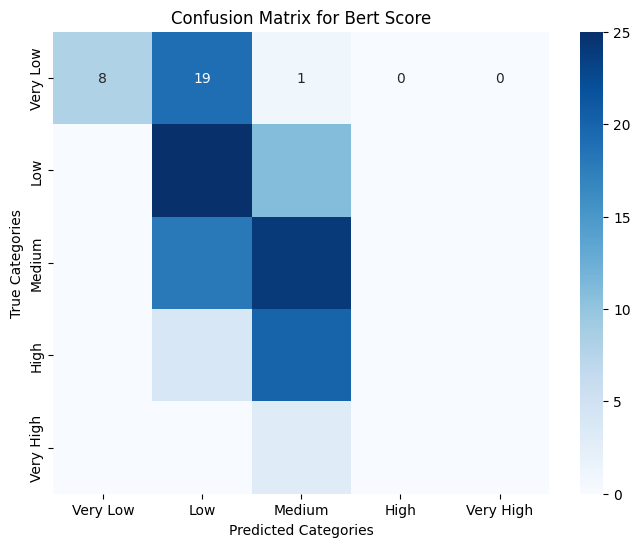

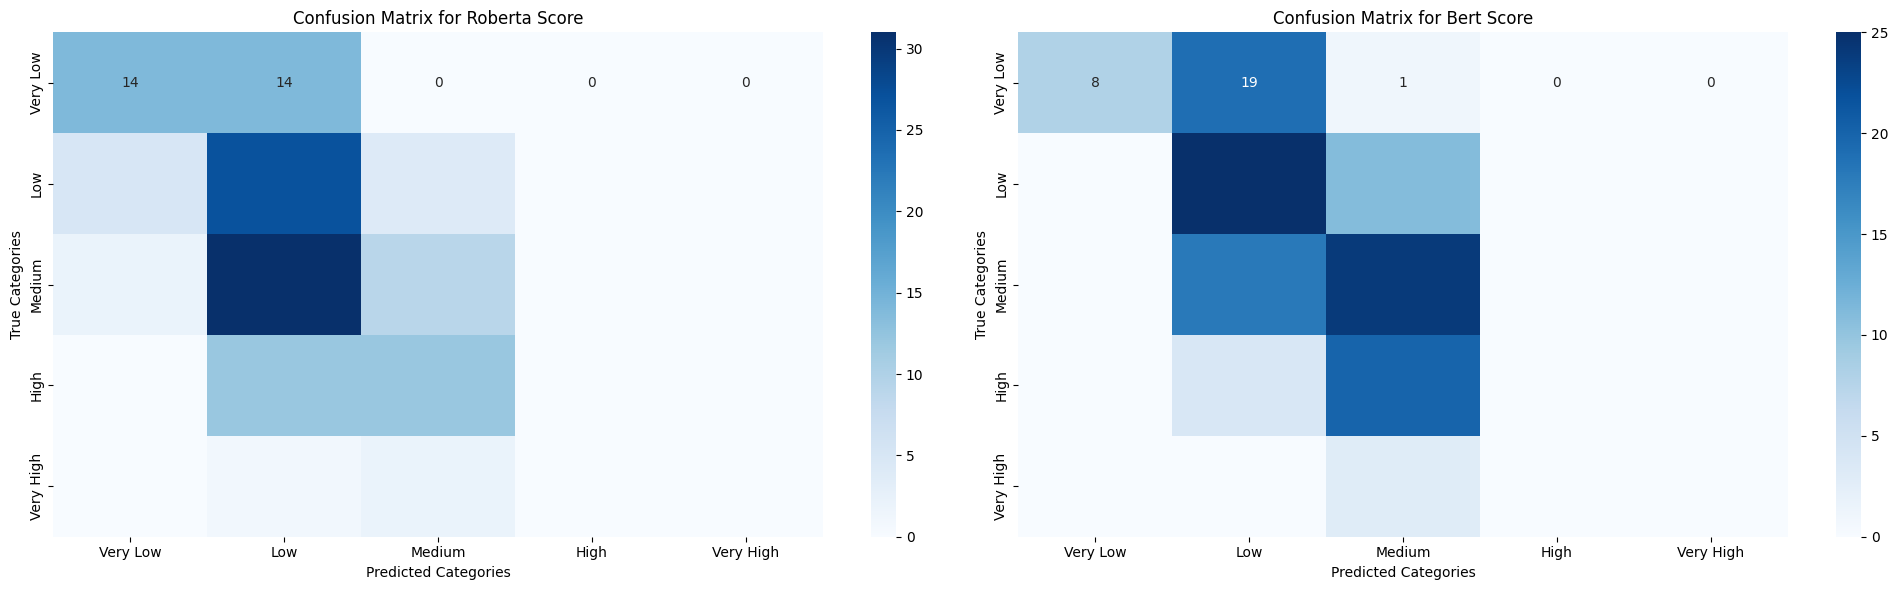

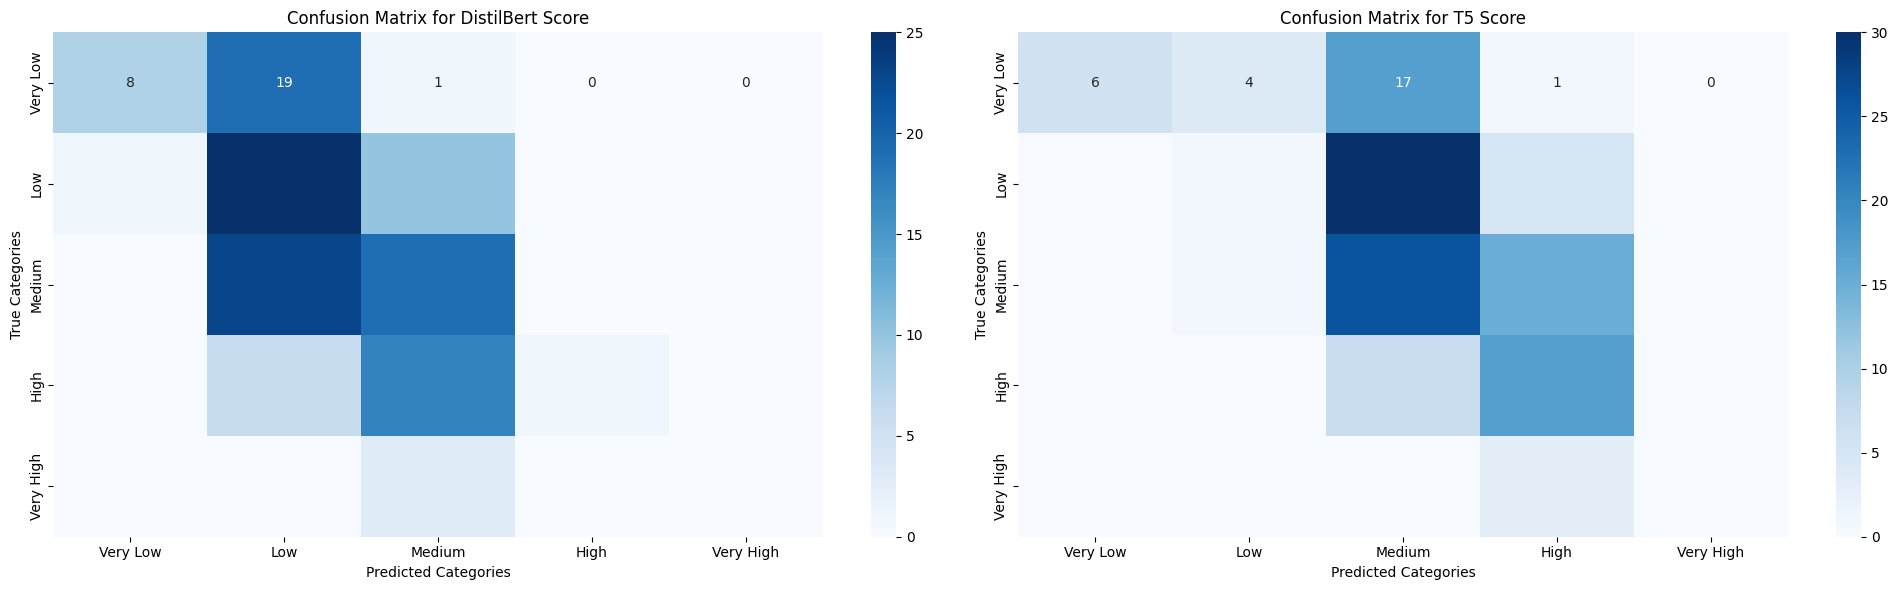

In [61]:
# Gerekli kütüphaneleri yeniden yükleyelim
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gerçek ve tahmin edilen kategorilerin sayısal değerlere eşlenmesi
#category_mapping = {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
category_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']  # Doğru sıralama
category_mapping = {category: i for i, category in enumerate(category_order)}
# Güncellenmiş Excel dosyasını tekrar yükleme
updated_file_path = 'total_sonuc_keywords.xlsx'
updated_total_sonuc_df = pd.read_excel(updated_file_path, sheet_name='total_sonuc_keywords')

def categorize_score(score):
    if score <= 20:
        return 'Very Low'
    elif score <= 40:
        return 'Low'
    elif score <= 60:
        return 'Medium'
    elif score <= 80:
        return 'High'
    else:
        return 'Very High'

# Orijinal ve model notlarını kategorilere ayırma
categorized_scores_updated = updated_total_sonuc_df.drop(['StudentID'], axis=1).applymap(categorize_score)

# Gerçek ve tahmin edilen kategorileri sayısal değerlere dönüştürme
y_true = categorized_scores_updated['Score'].map(category_mapping)
y_pred = categorized_scores_updated['Bert Score'].map(category_mapping)

# Confusion matrisini hesaplama
conf_mat = confusion_matrix(y_true, y_pred)

# Confusion matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_mapping.keys(), yticklabels=category_mapping.keys())
plt.title('Confusion Matrix for Bert Score')
plt.xlabel('Predicted Categories')
plt.ylabel('True Categories')
plt.show()

""" # Confusion matrislerini her model için ayrı ayrı hesaplayıp görselleştirelim
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 18))
axes = axes.flatten()  # 2D eksen dizisini 1D'ye düzleştir

for i, model in enumerate(updated_model_names):
    # Gerçek ve tahmin edilen kategorileri sayısal değerlere dönüştürme
    y_pred = categorized_scores_updated[model].map(category_mapping)

    # Confusion matrisini hesaplama
    conf_mat = confusion_matrix(y_true, y_pred)

    # Confusion matrisini görselleştirme
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=category_mapping.keys(), yticklabels=category_mapping.keys())
    axes[i].set_title(f'Confusion Matrix for {model}')
    axes[i].set_xlabel('Predicted Categories')
    axes[i].set_ylabel('True Categories')

plt.tight_layout()
plt.show() """

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
for i, model in enumerate(updated_model_names[:2]):
    y_pred = categorized_scores_updated[model].map(category_mapping)
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=category_mapping.keys(), yticklabels=category_mapping.keys())
    axes[i].set_title(f'Confusion Matrix for {model}')
    axes[i].set_xlabel('Predicted Categories')
    axes[i].set_ylabel('True Categories')

plt.tight_layout()
plt.show()

# Sonraki 3 model için confusion matrixleri görselleştirme
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
for i, model in enumerate(updated_model_names[2:]):
    y_pred = categorized_scores_updated[model].map(category_mapping)
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=category_mapping.keys(), yticklabels=category_mapping.keys())
    axes[i].set_title(f'Confusion Matrix for {model}')
    axes[i].set_xlabel('Predicted Categories')
    axes[i].set_ylabel('True Categories')


plt.tight_layout()
plt.show()

In [62]:
# add df_q1 with student id to the excel file if sheet exists rewrite it
with pd.ExcelWriter('total_sonuc_keywords.xlsx', mode='a', engine='openpyxl') as writer:
    df_q1.to_excel(writer, sheet_name='Q-1-results', index=False)

# add df_q2 with student id to the excel file if sheet exists rewrite it
with pd.ExcelWriter('total_sonuc_keywords.xlsx', mode='a', engine='openpyxl') as writer:
    df_q2.to_excel(writer, sheet_name='Q-2-results', index=False)

# add df_q3 with student id to the excel file if sheet exists rewrite it
with pd.ExcelWriter('total_sonuc_keywords.xlsx', mode='a', engine='openpyxl') as writer:
    df_q3.to_excel(writer, sheet_name='Q-3-results', index=False)

# add df_q4 with student id to the excel file if sheet exists rewrite it
with pd.ExcelWriter('total_sonuc_keywords.xlsx', mode='a', engine='openpyxl') as writer:
    df_q4.to_excel(writer, sheet_name='Q-4-results', index=False)

# add df_q5 with student id to the excel file if sheet exists rewrite it
with pd.ExcelWriter('total_sonuc_keywords.xlsx', mode='a', engine='openpyxl') as writer:
    df_q5.to_excel(writer, sheet_name='Q-5-results', index=False)



In [63]:
import pickle
ridge_pipe = pickle.load(open("reward_model_ridge.pkl", "rb"))
logit = pickle.load(open("reward_model_logistic.pkl", "rb"))

/Users/bkkas/anaconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bkkas/anaconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RidgeCV from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/bkkas/anaconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use a

In [64]:
# 1️⃣ Modülü içe aktar
from rlhf_multi_calibration import run_all_questions, build_rlhf_models

# 2️⃣ Tüm sorular için çalıştır (ya da sadece Q-2 istersen)
run_all_questions([1, 2, 3, 4, 5])
# veya sadece:
# build_rlhf_models(2)



🔹 Processing Q-1 / Q-1-results
🧠 Selected human preference samples:
     StudentID  Score                                             Answer
0  20220808608      2             alchemy algebra abstraction experiment
1  20190808021      8  ali ku credit u proved astronomical facts evid...
2  20200808045     10  calculate number days year bold circle works g...
3  20220808076     16  proud glass optic cs quarantine ne surgery eye...
4  20230808066     18  optics - prisms elements geography book school...
✅ Q-1 tamamlandı → 'Q-1-calibrated.xlsx' oluşturuldu.

🔹 Processing Q-2 / Q-2-results
🧠 Selected human preference samples:
     StudentID  Score                                             Answer
0  20210808048      0  probably important civil right conflict intere...
1  20220808005      8  law distinct power distinction public private ...
2  20190808021     16  introduced 12 tables 12 tables 12 legal rules ...
3  20220808052     20  lawyer jury prison everybody innocent proven g...
✅ Q-2

In [65]:
!python rlhf_rank_preserving_q2.py


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



🔹 Rank-Preserving RLHF-Lite Calibration for Q-2
🧠 Selected human reference samples:
     StudentID  Score                                             Answer
0  20210808048      0  probably important civil right conflict intere...
1  20220808005      8  law distinct power distinction public private ...
2  20190808021     16  introduced 12 tables 12 tables 12 legal rules ...
3  20220808052     20  lawyer jury prison everybody innocent proven g...
✅ Q-2 rank-preserving calibration tamamlandı → 'Q-2-calibrated.xlsx' oluşturuldu.
⚖️  Sıralama korunarak insan dağılımına hizalandı (0 hiçbir zaman yükselmedi).


In [66]:
!python rlhf_rank_preserving_q2_strict.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



🔹 Rank-Preserving RLHF-Lite Calibration for Q-2 (Strict Zero Mode)
🧠 Selected human reference samples:
     StudentID  Score                                             Answer
0  20210808048      0  probably important civil right conflict intere...
1  20220808005      8  law distinct power distinction public private ...
2  20190808021     16  introduced 12 tables 12 tables 12 legal rules ...
3  20220808052     20  lawyer jury prison everybody innocent proven g...
✅ Q-2 strict rank-preserving calibration tamamlandı → 'Q-2-calibrated-strict.xlsx' oluşturuldu.
⚖️  Boş veya kopya cevaplar sabit 0 aldı; sıralama korundu.


In [67]:
!python rlhf_rank_preserving_q2_damped.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



🔹 Rank-Preserving RLHF-Lite Calibration for Q-2 (5-Point Dampened)
🧠 Selected human reference samples:
     StudentID  Score                                             Answer
0  20210808048      0  probably important civil right conflict intere...
1  20220808005      8  law distinct power distinction public private ...
2  20190808021     16  introduced 12 tables 12 tables 12 legal rules ...
3  20220808052     20  lawyer jury prison everybody innocent proven g...
✅ Q-2 dampened rank-preserving calibration tamamlandı → 'Q-2-calibrated-damped.xlsx' oluşturuldu.
⚖️  5'ten düşük notlar en fazla +5 puan artış alabilir; sıralama korundu.


In [68]:
!python rlhf_rank_preserving_damped_all.py


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



🔹 Rank-Preserving RLHF-Lite (All Questions) başlatılıyor...

✅ Q-1 tamamlandı → Q-1-calibrated-damped.xlsx
✅ Q-2 tamamlandı → Q-2-calibrated-damped.xlsx
✅ Q-3 tamamlandı → Q-3-calibrated-damped.xlsx
✅ Q-4 tamamlandı → Q-4-calibrated-damped.xlsx
✅ Q-5 tamamlandı → Q-5-calibrated-damped.xlsx

📊 Sınav Geneli Analiz:
• Korelasyon (Human vs Model): 0.727
• Ortalama fark (Model - Human): -9.76 puan
✅ 'Exam_Total_Comparison.xlsx' oluşturuldu (her öğrencinin toplamı).


--- Generating Scatter Plots for Q-2 (Before vs. After Calibration) from Excel Sheets ---
✅ Bulundu: total_sonuc_keywords.xlsx
✅ Bulundu: Q-2-calibrated-damped.xlsx
Okunuyor: 'total_sonuc_keywords.xlsx' -> Sayfa: 'Q-2-results'
Okunuyor: 'Q-2-calibrated-damped.xlsx' -> Sayfa: 'Calibrated Results'
✅ Kaydedilen grafik: figure_2a_baseline_q2.png
✅ Kaydedilen grafik: figure_2b_calibrated_q2.png


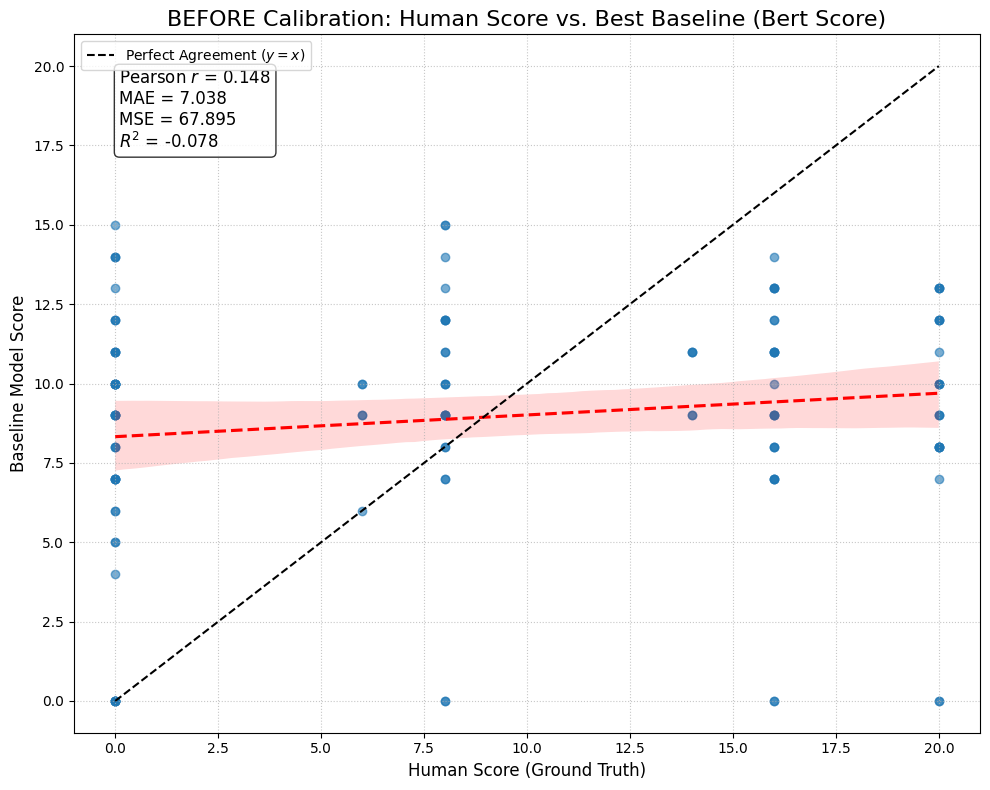

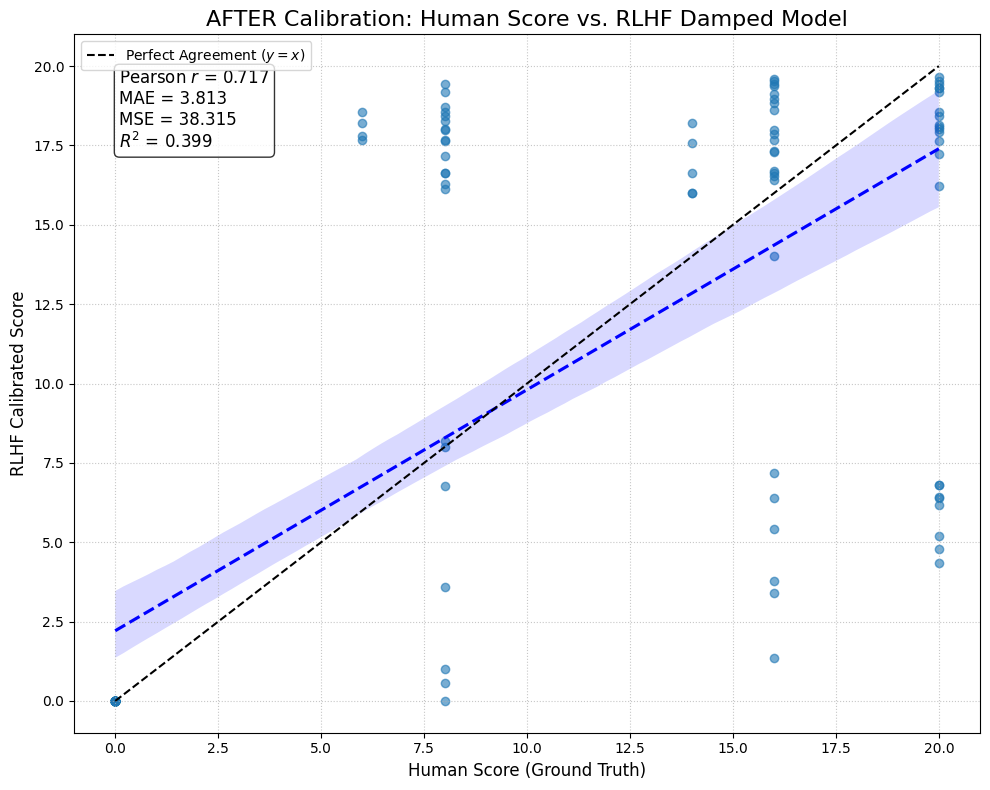

In [69]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os # Dosya varlığını kontrol etmek için

# --- EXCEL DOSYA ADLARI VE SAYFA ADLARI ---
excel_file_before = "total_sonuc_keywords.xlsx"
sheet_name_before = "Q-2-results"

excel_file_after = "Q-2-calibrated-damped.xlsx"
sheet_name_after = "Calibrated Results"

print("--- Generating Scatter Plots for Q-2 (Before vs. After Calibration) from Excel Sheets ---")

# --- Dosyaların varlığını kontrol et ---
if not os.path.exists(excel_file_before):
    print(f"🚨 HATA: Excel dosyası bulunamadı: '{os.path.abspath(excel_file_before)}'")
    print("Lütfen script'in ve Excel dosyalarının aynı dizinde olduğundan emin olun veya dosya yolunu güncelleyin.")
    exit()
else:
    print(f"✅ Bulundu: {excel_file_before}")

if not os.path.exists(excel_file_after):
    print(f"🚨 HATA: Excel dosyası bulunamadı: '{os.path.abspath(excel_file_after)}'")
    print("Lütfen script'in ve Excel dosyalarının aynı dizinde olduğundan emin olun veya dosya yolunu güncelleyin.")
    exit()
else:
    print(f"✅ Bulundu: {excel_file_after}")

try:
    # --- Verileri Yükle (Excel Sayfalarından) ---
    print(f"Okunuyor: '{excel_file_before}' -> Sayfa: '{sheet_name_before}'")
    df_before = pd.read_excel(excel_file_before, sheet_name=sheet_name_before)

    print(f"Okunuyor: '{excel_file_after}' -> Sayfa: '{sheet_name_after}'")
    df_after_damped = pd.read_excel(excel_file_after, sheet_name=sheet_name_after)

    # --- Karşılaştırılacak Sütunlar ---
    human_col = 'Score'
    baseline_col = 'Bert Score' # Q-2 için en iyi baseline
    calib_col = 'RLHF-Calibrated Score' # En iyi kalibre model (Damped)

    # --- Temiz Veri (NaN olmayan satırlar) ---
    df_before_clean = df_before[[human_col, baseline_col]].dropna()
    df_after_clean = df_after_damped[[human_col, calib_col]].dropna()

    # --- Grafik için Metrikleri Hesapla ---

    # Baseline (Bert)
    r_base, _ = pearsonr(df_before_clean[human_col], df_before_clean[baseline_col])
    mae_base = mean_absolute_error(df_before_clean[human_col], df_before_clean[baseline_col])
    mse_base = mean_squared_error(df_before_clean[human_col], df_before_clean[baseline_col])
    r2_base = r2_score(df_before_clean[human_col], df_before_clean[baseline_col])

    # Calibrated (Damped)
    r_calib, _ = pearsonr(df_after_clean[human_col], df_after_clean[calib_col])
    mae_calib = mean_absolute_error(df_after_clean[human_col], df_after_clean[calib_col])
    mse_calib = mean_squared_error(df_after_clean[human_col], df_after_clean[calib_col])
    r2_calib = r2_score(df_after_clean[human_col], df_after_clean[calib_col])

    # --- Çizim ---
    max_score = 20 # Soru için maksimum puan

    # 1. Kalibrasyon ÖNCESİ (En İyi Baseline: Bert)
    plt.figure(figsize=(10, 8))
    sns.regplot(data=df_before_clean, x=human_col, y=baseline_col,
                line_kws={'color': 'red', 'linestyle': '--'},
                scatter_kws={'alpha': 0.6})
    plt.plot([0, max_score], [0, max_score], 'k--', label='Perfect Agreement ($y=x$)') # 1:1 çizgisi
    plt.title(f'BEFORE Calibration: Human Score vs. Best Baseline ({baseline_col})', fontsize=16)
    plt.xlabel('Human Score (Ground Truth)', fontsize=12)
    plt.ylabel('Baseline Model Score', fontsize=12)
    plt.xlim(-1, max_score + 1) # Görünürlük için limitleri hafifçe ayarladım
    plt.ylim(-1, max_score + 1) # Görünürlük için limitleri hafifçe ayarladım
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    stats_text = (f"Pearson $r$ = {r_base:.3f}\n"
                  f"MAE = {mae_base:.3f}\n"
                  f"MSE = {mse_base:.3f}\n"
                  f"$R^2$ = {r2_base:.3f}")
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.savefig('figure_2a_baseline_q2.png', dpi=300)
    print("✅ Kaydedilen grafik: figure_2a_baseline_q2.png")

    # 2. Kalibrasyon SONRASI (En İyi Model: RLHF Damped)
    plt.figure(figsize=(10, 8))
    sns.regplot(data=df_after_clean, x=human_col, y=calib_col,
                line_kws={'color': 'blue', 'linestyle': '--'},
                scatter_kws={'alpha': 0.6})
    plt.plot([0, max_score], [0, max_score], 'k--', label='Perfect Agreement ($y=x$)') # 1:1 çizgisi
    plt.title(f'AFTER Calibration: Human Score vs. RLHF Damped Model', fontsize=16)
    plt.xlabel('Human Score (Ground Truth)', fontsize=12)
    plt.ylabel('RLHF Calibrated Score', fontsize=12)
    plt.xlim(-1, max_score + 1) # Görünürlük için limitleri hafifçe ayarladım
    plt.ylim(-1, max_score + 1) # Görünürlük için limitleri hafifçe ayarladım
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    stats_text = (f"Pearson $r$ = {r_calib:.3f}\n"
                  f"MAE = {mae_calib:.3f}\n"
                  f"MSE = {mse_calib:.3f}\n"
                  f"$R^2$ = {r2_calib:.3f}")
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.savefig('figure_2b_calibrated_q2.png', dpi=300)
    print("✅ Kaydedilen grafik: figure_2b_calibrated_q2.png")

except FileNotFoundError as e:
    # Bu hata, Excel dosyası bulunamazsa oluşur.
    print(f"🚨 Excel dosyası okunamadı: {e}")
except ValueError as e:
    # Bu hata, Excel içinde belirtilen sayfa adı bulunamazsa oluşur.
    print(f"🚨 HATA: Excel dosyasında belirtilen sayfa bulunamadı: {e}")
    if 'sheet_name' in str(e):
        print(f"   -> Lütfen '{excel_file_before}' içinde '{sheet_name_before}' sayfasının")
        print(f"   -> ve '{excel_file_after}' içinde '{sheet_name_after}' sayfasının var olduğundan emin olun.")
except Exception as e:
    # Diğer olası hatalar
    print(f"🚨 Bir hata oluştu: {e}")

--- Generating Combined Scatter Plot for Q-2 (Before vs. After) from Excel Sheets ---
✅ Kaydedilen birleşik grafik: figure_2_combined_q2.png


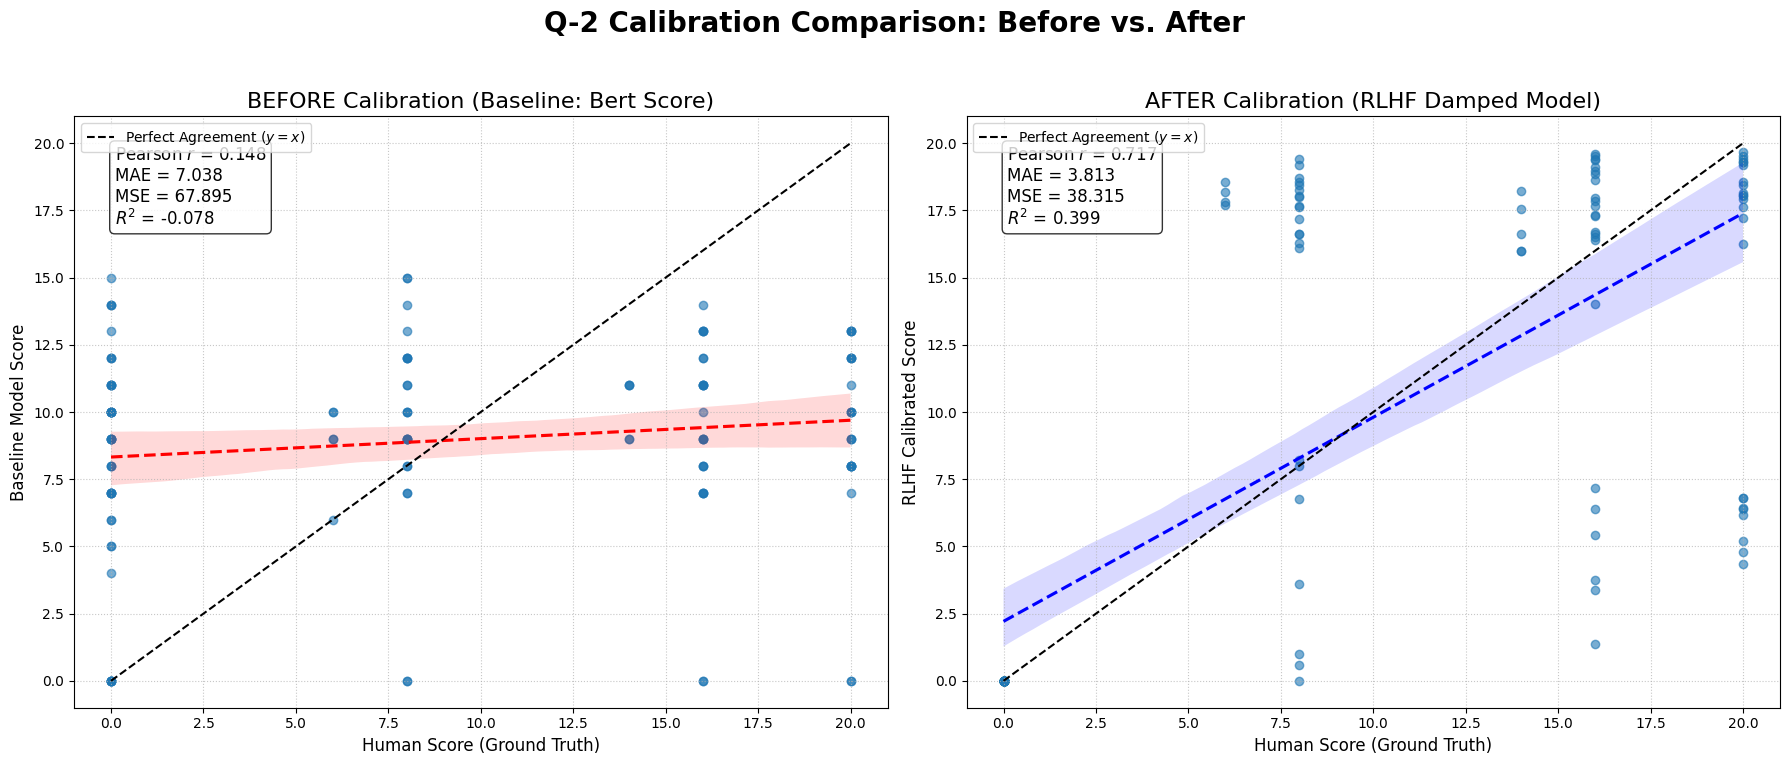

In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os # Dosya varlığını kontrol etmek için

# --- EXCEL DOSYA ADLARI VE SAYFA ADLARI ---
excel_file_before = "total_sonuc_keywords.xlsx"
sheet_name_before = "Q-2-results"

excel_file_after = "Q-2-calibrated-damped.xlsx"
sheet_name_after = "Calibrated Results"

print("--- Generating Combined Scatter Plot for Q-2 (Before vs. After) from Excel Sheets ---")

# --- Dosyaların varlığını kontrol et ---
if not os.path.exists(excel_file_before):
    print(f"🚨 HATA: Excel dosyası bulunamadı: '{os.path.abspath(excel_file_before)}'")
    exit()
if not os.path.exists(excel_file_after):
    print(f"🚨 HATA: Excel dosyası bulunamadı: '{os.path.abspath(excel_file_after)}'")
    exit()

try:
    # --- Verileri Yükle ---
    df_before = pd.read_excel(excel_file_before, sheet_name=sheet_name_before)
    df_after_damped = pd.read_excel(excel_file_after, sheet_name=sheet_name_after)

    # --- Karşılaştırılacak Sütunlar ---
    human_col = 'Score'
    baseline_col = 'Bert Score' # Q-2 için en iyi baseline
    calib_col = 'RLHF-Calibrated Score' # En iyi kalibre model (Damped)

    # --- Temiz Veri ---
    df_before_clean = df_before[[human_col, baseline_col]].dropna()
    df_after_clean = df_after_damped[[human_col, calib_col]].dropna()

    # --- Metrikleri Hesapla ---
    # Baseline (Bert)
    r_base, _ = pearsonr(df_before_clean[human_col], df_before_clean[baseline_col])
    mae_base = mean_absolute_error(df_before_clean[human_col], df_before_clean[baseline_col])
    mse_base = mean_squared_error(df_before_clean[human_col], df_before_clean[baseline_col])
    r2_base = r2_score(df_before_clean[human_col], df_before_clean[baseline_col])

    # Calibrated (Damped)
    r_calib, _ = pearsonr(df_after_clean[human_col], df_after_clean[calib_col])
    mae_calib = mean_absolute_error(df_after_clean[human_col], df_after_clean[calib_col])
    mse_calib = mean_squared_error(df_after_clean[human_col], df_after_clean[calib_col])
    r2_calib = r2_score(df_after_clean[human_col], df_after_clean[calib_col])

    # --- Birleşik Çizim ---
    max_score = 20
    fig, axes = plt.subplots(1, 2, figsize=(18, 8)) # 1 satır, 2 sütun

    # --- Sol Grafik: Kalibrasyon ÖNCESİ ---
    ax = axes[0]
    sns.regplot(ax=ax, data=df_before_clean, x=human_col, y=baseline_col,
                line_kws={'color': 'red', 'linestyle': '--'},
                scatter_kws={'alpha': 0.6})
    ax.plot([0, max_score], [0, max_score], 'k--', label='Perfect Agreement ($y=x$)')
    ax.set_title(f'BEFORE Calibration (Baseline: {baseline_col})', fontsize=16)
    ax.set_xlabel('Human Score (Ground Truth)', fontsize=12)
    ax.set_ylabel('Baseline Model Score', fontsize=12)
    ax.set_xlim(-1, max_score + 1)
    ax.set_ylim(-1, max_score + 1)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.7)
    stats_text_base = (f"Pearson $r$ = {r_base:.3f}\n"
                       f"MAE = {mae_base:.3f}\n"
                       f"MSE = {mse_base:.3f}\n"
                       f"$R^2$ = {r2_base:.3f}")
    ax.text(0.05, 0.95, stats_text_base, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # --- Sağ Grafik: Kalibrasyon SONRASI ---
    ax = axes[1]
    sns.regplot(ax=ax, data=df_after_clean, x=human_col, y=calib_col,
                line_kws={'color': 'blue', 'linestyle': '--'},
                scatter_kws={'alpha': 0.6})
    ax.plot([0, max_score], [0, max_score], 'k--', label='Perfect Agreement ($y=x$)')
    ax.set_title(f'AFTER Calibration (RLHF Damped Model)', fontsize=16)
    ax.set_xlabel('Human Score (Ground Truth)', fontsize=12)
    ax.set_ylabel('RLHF Calibrated Score', fontsize=12)
    ax.set_xlim(-1, max_score + 1)
    ax.set_ylim(-1, max_score + 1)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.7)
    stats_text_calib = (f"Pearson $r$ = {r_calib:.3f}\n"
                        f"MAE = {mae_calib:.3f}\n"
                        f"MSE = {mse_calib:.3f}\n"
                        f"$R^2$ = {r2_calib:.3f}")
    ax.text(0.05, 0.95, stats_text_calib, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # --- Genel Ayarlamalar ve Kaydetme ---
    fig.suptitle('Q-2 Calibration Comparison: Before vs. After', fontsize=20, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ana başlık için yer bırak
    plt.savefig('figure_2_combined_q2.png', dpi=300)
    print("✅ Kaydedilen birleşik grafik: figure_2_combined_q2.png")

except Exception as e:
    print(f"🚨 Bir hata oluştu: {e}")

--- Generating Score Distribution Box Plot for Q-2 from Excel Sheet ---
✅ Bulundu: Q-2-calibrated-damped.xlsx
Okunuyor: 'Q-2-calibrated-damped.xlsx' -> Sayfa: 'Calibrated Results'

✅ Kaydedilen kutu grafiği: figure_3_boxplot_q2.png
Grafik, üç puanlama yönteminin dağılımlarını (aralık, medyan, çeyrekler) görsel olarak karşılaştırır.


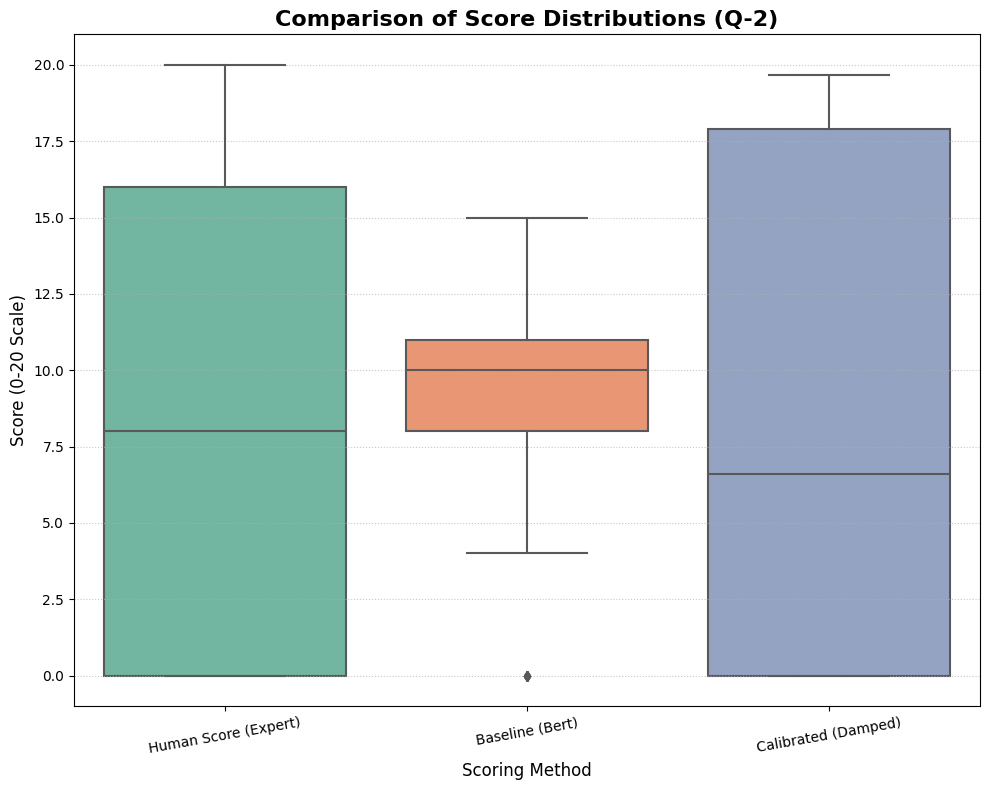

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os # Dosya varlığını kontrol etmek için

# --- EXCEL DOSYA ADI VE SAYFA ADI ---
# Kalibre edilmiş dosya tüm gerekli sütunları içerir (Hoca, Baseline Bert, Kalibre Damped)
excel_file = "Q-2-calibrated-damped.xlsx"
sheet_name = "Calibrated Results"

print("--- Generating Score Distribution Box Plot for Q-2 from Excel Sheet ---")

# --- Dosyanın varlığını kontrol et ---
if not os.path.exists(excel_file):
    print(f"🚨 HATA: Excel dosyası bulunamadı: '{os.path.abspath(excel_file)}'")
    print("Lütfen script'in ve Excel dosyasının aynı dizinde olduğundan emin olun veya dosya yolunu güncelleyin.")
    exit()
else:
    print(f"✅ Bulundu: {excel_file}")

try:
    # --- Veriyi Yükle ---
    print(f"Okunuyor: '{excel_file}' -> Sayfa: '{sheet_name}'")
    df_full = pd.read_excel(excel_file, sheet_name=sheet_name)

    # --- Karşılaştırma için Veri Çerçevesi Hazırla ---
    cols_to_compare = ['Score', 'Bert Score', 'RLHF-Calibrated Score']
    # Sadece bu 3 sütunda NaN olmayan satırları al
    df_compare = df_full[cols_to_compare].dropna().copy()

    # İsimleri daha anlaşılır yap (İngilizce)
    df_compare = df_compare.rename(columns={
        'Score': 'Human Score (Expert)',
        'Bert Score': 'Baseline (Bert)',
        'RLHF-Calibrated Score': 'Calibrated (Damped)'
    })

    # --- Görselleştirme için Veriyi Uzun Formata Çevir ---
    df_melted = df_compare.melt(
        var_name='Scoring Method',
        value_name='Score (0-20)'
        )

    # --- Kutu Grafiğini Çiz ---
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=df_melted, x='Scoring Method', y='Score (0-20)', palette="Set2")

    plt.title('Comparison of Score Distributions (Q-2)', fontsize=16, weight='bold')
    plt.xlabel('Scoring Method', fontsize=12)
    plt.ylabel('Score (0-20 Scale)', fontsize=12)
    plt.xticks(rotation=10) # Etiketlerin üst üste binmesini engelle
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.ylim(-1, 21) # Y eksenini 0-20 aralığına odakla

    plt.tight_layout()
    plt.savefig('figure_3_boxplot_q2.png', dpi=300)

    print("\n✅ Kaydedilen kutu grafiği: figure_3_boxplot_q2.png")
    print("Grafik, üç puanlama yönteminin dağılımlarını (aralık, medyan, çeyrekler) görsel olarak karşılaştırır.")

except FileNotFoundError as e:
    print(f"🚨 Excel dosyası okunamadı (tekrar kontrol): {e}")
except ValueError as e:
    print(f"🚨 HATA: Excel dosyasında belirtilen sayfa bulunamadı: {e}")
except Exception as e:
    print(f"🚨 Bir hata oluştu: {e}")

In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import os # Dosya varlığını kontrol etmek için

# --- EXCEL DOSYA ADLARI VE SAYFA ADLARI ---
excel_file_before = "total_sonuc_keywords.xlsx"
sheet_name_before = "Q-2-results"

excel_file_after = "Q-2-calibrated-damped.xlsx"
sheet_name_after = "Calibrated Results"

print("--- Calculating Metrics for Q-2 (Before vs. After Calibration) from Excel Sheets ---")

# --- Dosyaların varlığını kontrol et ---
if not os.path.exists(excel_file_before):
    print(f"🚨 HATA: Excel dosyası bulunamadı: '{os.path.abspath(excel_file_before)}'")
    exit()
if not os.path.exists(excel_file_after):
    print(f"🚨 HATA: Excel dosyası bulunamadı: '{os.path.abspath(excel_file_after)}'")
    exit()

try:
    # --- Verileri Yükle ---
    print(f"Okunuyor: '{excel_file_before}' -> Sayfa: '{sheet_name_before}'")
    df_before = pd.read_excel(excel_file_before, sheet_name=sheet_name_before)

    print(f"Okunuyor: '{excel_file_after}' -> Sayfa: '{sheet_name_after}'")
    df_after_damped = pd.read_excel(excel_file_after, sheet_name=sheet_name_after)

    # --- Karşılaştırılacak Sütunlar ---
    human_col = 'Score'
    baseline_col = 'Bert Score' # Q-2 için en iyi baseline
    calib_col = 'RLHF-Calibrated Score' # En iyi kalibre model (Damped)

    # --- Temiz Veri (NaN olmayan satırlar) ---
    # Baseline için: Hem hoca skoru hem de Bert skoru olan satırlar
    df_before_clean = df_before[[human_col, baseline_col]].dropna()

    # Kalibre edilmiş için: Hem hoca skoru hem de kalibre skoru olan satırlar
    # ÖNEMLİ: Kalibre edilmiş veri seti, baseline'dan farklı sayıda satır içerebilir.
    # Bu yüzden iki ayrı temizleme yapıyoruz.
    df_after_clean = df_after_damped[[human_col, calib_col]].dropna()

    # --- Metrikleri Hesapla ---

    # 1. Kalibrasyon ÖNCESİ (Baseline Bert)
    print(f"\n--- Metrics BEFORE Calibration (Baseline: {baseline_col}) ---")
    if not df_before_clean.empty:
        human_before = df_before_clean[human_col]
        model_before = df_before_clean[baseline_col]

        r_base, _ = pearsonr(human_before, model_before)
        mae_base = mean_absolute_error(human_before, model_before)
        mse_base = mean_squared_error(human_before, model_before)
        r2_base = r2_score(human_before, model_before)

        print(f"Number of valid samples: {len(df_before_clean)}")
        print(f"Pearson Correlation (r): {r_base:.4f}")
        print(f"Mean Absolute Error (MAE): {mae_base:.4f}")
        print(f"Mean Squared Error (MSE): {mse_base:.4f}")
        print(f"R-squared (R^2):          {r2_base:.4f}")
    else:
        print("No valid data found for baseline comparison.")


    # 2. Kalibrasyon SONRASI (RLHF Damped)
    print(f"\n--- Metrics AFTER Calibration (Model: {calib_col}) ---")
    if not df_after_clean.empty:
        human_after = df_after_clean[human_col]
        model_after = df_after_clean[calib_col]

        r_calib, _ = pearsonr(human_after, model_after)
        mae_calib = mean_absolute_error(human_after, model_after)
        mse_calib = mean_squared_error(human_after, model_after)
        r2_calib = r2_score(human_after, model_after)

        print(f"Number of valid samples: {len(df_after_clean)}")
        print(f"Pearson Correlation (r): {r_calib:.4f}")
        print(f"Mean Absolute Error (MAE): {mae_calib:.4f}")
        print(f"Mean Squared Error (MSE): {mse_calib:.4f}")
        print(f"R-squared (R^2):          {r2_calib:.4f}")
    else:
        print("No valid data found for calibrated comparison.")

    # --- İyileştirme Yüzdeleri ---
    print("\n--- Improvement Summary ---")
    if not df_before_clean.empty and not df_after_clean.empty:
        # İyileştirme sadece metrikler hesaplanabildiyse gösterilir
        if 'r_base' in locals() and 'r_calib' in locals():
             r_improvement = ((r_calib - r_base) / abs(r_base)) * 100 if r_base != 0 else float('inf')
             print(f"Pearson r Improvement: {r_improvement:.2f}%")
        if 'mae_base' in locals() and 'mae_calib' in locals():
             mae_improvement = ((mae_base - mae_calib) / mae_base) * 100 if mae_base != 0 else float('inf')
             print(f"MAE Reduction:         {mae_improvement:.2f}%")
        if 'mse_base' in locals() and 'mse_calib' in locals():
             mse_improvement = ((mse_base - mse_calib) / mse_base) * 100 if mse_base != 0 else float('inf')
             print(f"MSE Reduction:         {mse_improvement:.2f}%")
        if 'r2_base' in locals() and 'r2_calib' in locals():
             # R^2 iyileşmesi mutlak fark olarak veya % artış olarak gösterilebilir. % artış daha anlamlı olabilir.
             # Dikkat: R^2 negatif olabilir, bu yüzden mutlak değere göre % hesaplamak yanıltıcı olabilir.
             # Mutlak farkı ve basit artışı gösterelim.
             r2_abs_improvement = r2_calib - r2_base
             print(f"R^2 Absolute Increase: +{r2_abs_improvement:.4f}")
             if r2_base > 0: # Negatiften pozitife geçişte % hesaplamak anlamsız
                 r2_perc_improvement = (r2_abs_improvement / r2_base) * 100
                 print(f"R^2 Relative Increase: {r2_perc_improvement:.2f}%")

except FileNotFoundError as e:
    print(f"🚨 Excel dosyası okunamadı: {e}")
except ValueError as e:
    print(f"🚨 HATA: Excel dosyasında belirtilen sayfa bulunamadı: {e}")
except KeyError as e:
    print(f"🚨 HATA: Excel dosyasında beklenen sütun adı bulunamadı: {e}")
    print("   -> Lütfen sütun adlarının ('Score', 'Bert Score', 'RLHF-Calibrated Score') doğru olduğundan emin olun.")
except Exception as e:
    print(f"🚨 Bir hata oluştu: {e}")

--- Calculating Metrics for Q-2 (Before vs. After Calibration) from Excel Sheets ---
Okunuyor: 'total_sonuc_keywords.xlsx' -> Sayfa: 'Q-2-results'
Okunuyor: 'Q-2-calibrated-damped.xlsx' -> Sayfa: 'Calibrated Results'

--- Metrics BEFORE Calibration (Baseline: Bert Score) ---
Number of valid samples: 133
Pearson Correlation (r): 0.1479
Mean Absolute Error (MAE): 7.0376
Mean Squared Error (MSE): 67.8947
R-squared (R^2):          -0.0776

--- Metrics AFTER Calibration (Model: RLHF-Calibrated Score) ---
Number of valid samples: 126
Pearson Correlation (r): 0.7175
Mean Absolute Error (MAE): 3.8126
Mean Squared Error (MSE): 38.3148
R-squared (R^2):          0.3986

--- Improvement Summary ---
Pearson r Improvement: 385.10%
MAE Reduction:         45.83%
MSE Reduction:         43.57%
R^2 Absolute Increase: +0.4761


✅ 'pipeline_diagram_final_v3.png' successfully created and saved.
You can include this image in your LaTeX file using \includegraphics{pipeline_diagram_final_v3.png}.


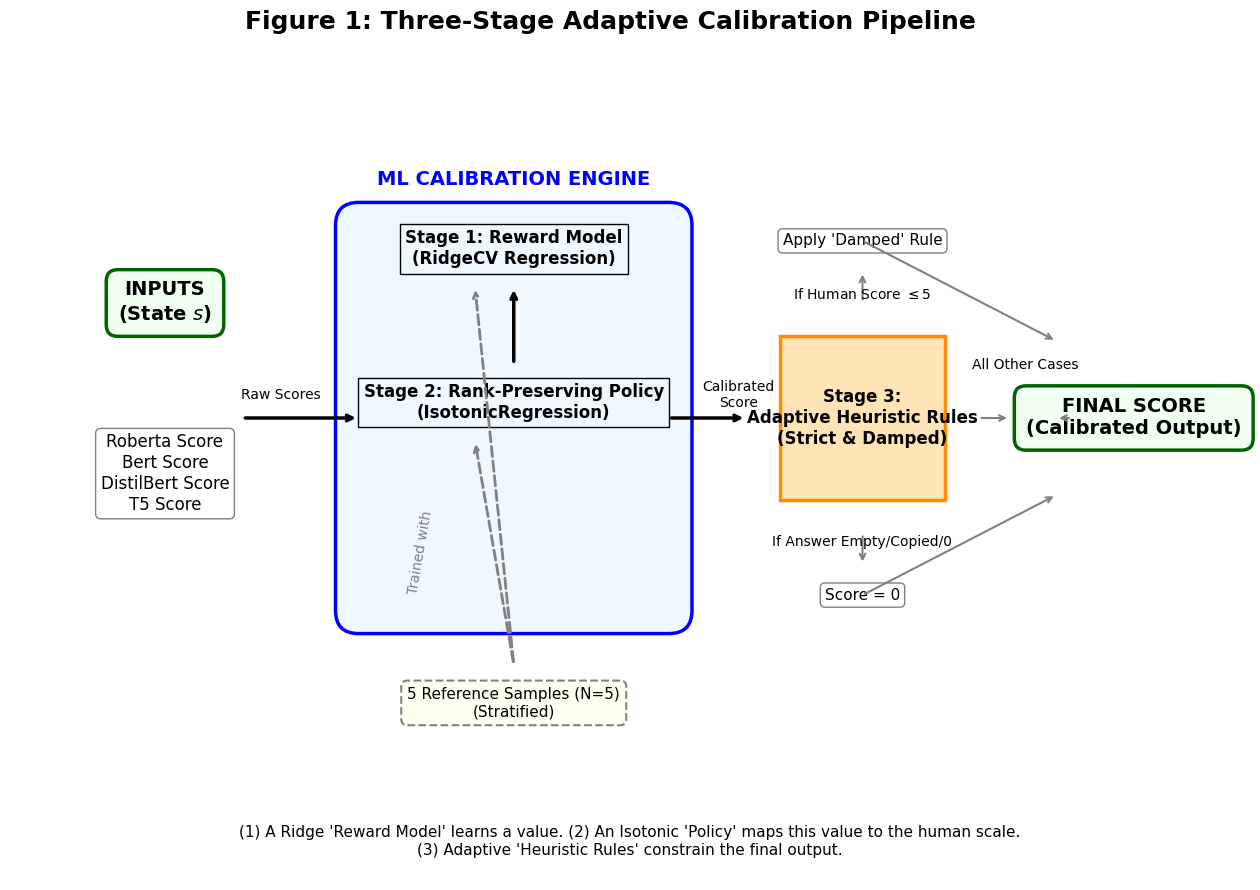

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# --- Diyagramı Oluştur ---
fig, ax = plt.subplots(figsize=(16, 10)) # Daha da genişlettim
ax.set_xlim(0, 16) # X limitini artırdım
ax.set_ylim(0, 10)
ax.axis('off')

# --- Stil Tanımları ---
io_pad = 0.6 # Kutuların içindeki boşluğu artır
box_style = dict(boxstyle=f'round,pad={io_pad}', fc='aliceblue', ec='b', lw=2.5) # Çizgi kalınlığı
io_style = dict(boxstyle=f'round,pad={io_pad}', fc='honeydew', ec='darkgreen', lw=2.5)
ref_style = dict(boxstyle='round,pad=0.4', fc='ivory', ec='gray', lw=1.5, ls='--')
# Ok stilleri
arrow_props = dict(arrowstyle='->', lw=2.5, color='black') # Kalın oklar
# Kural ok stilleri
rule_arrow_props = dict(arrowstyle='->', lw=1.5, color='gray') # Daha ince kural okları
# Font boyutları
title_fontsize = 18
box_title_fontsize = 14
box_content_fontsize = 12
arrow_label_fontsize = 10
rule_label_fontsize = 10


# --- 1. Sütun: GİRDİLER (Inputs) ---
ax.text(2, 7.5, "INPUTS\n(State $s$)", ha='center', va='center', bbox=io_style, fontsize=box_title_fontsize, weight='bold')
ax.text(2, 5.8,
        "Roberta Score\n"
        "Bert Score\n"
        "DistilBert Score\n"
        "T5 Score",
        ha='center', va='top', bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'), fontsize=box_content_fontsize)

# --- 2. Sütun: ML POLİTİKASI (ML Policy) ---
ml_box_x_start = 4.5
ml_box_width = 4.0
ml_box_y_start = 3.5
ml_box_height = 5
ml_box = patches.FancyBboxPatch((ml_box_x_start, ml_box_y_start), ml_box_width, ml_box_height, boxstyle=f"round,pad={io_pad}", fc='aliceblue', ec='b', lw=2.5, mutation_scale=0.5)
ax.add_patch(ml_box)

ax.text(ml_box_x_start + ml_box_width/2, 8.2, "Stage 1: Reward Model\n(RidgeCV Regression)", ha='center', va='center', bbox=dict(fc='aliceblue'), fontsize=box_content_fontsize, weight='bold')
ax.annotate("", xy=(ml_box_x_start + ml_box_width/2, 7.7), xytext=(ml_box_x_start + ml_box_width/2, 6.7), arrowprops=arrow_props)
ax.text(ml_box_x_start + ml_box_width/2, 6.2, "Stage 2: Rank-Preserving Policy\n(IsotonicRegression)", ha='center', va='center', bbox=dict(fc='aliceblue'), fontsize=box_content_fontsize, weight='bold')
ax.text(ml_box_x_start + ml_box_width/2, 9.1, "ML CALIBRATION ENGINE", ha='center', va='center', fontsize=box_title_fontsize, weight='bold', color='b')

# --- 5 Referans Örnek (Eğitim) ---
ax.text(ml_box_x_start + ml_box_width/2, 2.3, "5 Reference Samples (N=5)\n(Stratified)", ha='center', va='center', bbox=ref_style, fontsize=box_content_fontsize-1)
# Oklar (Referanstan motorun iki aşamasına da)
ax.annotate("", xy=(ml_box_x_start + ml_box_width/2 - 0.5, 5.7), xytext=(ml_box_x_start + ml_box_width/2, 2.8),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray', linestyle='--'))
ax.annotate("", xy=(ml_box_x_start + ml_box_width/2 - 0.5, 7.7), xytext=(ml_box_x_start + ml_box_width/2, 2.8),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray', linestyle='--'))
ax.text(ml_box_x_start + ml_box_width/2 - 1.2, 4.25, "Trained with", ha='center', va='center', fontsize=arrow_label_fontsize, color='gray', rotation=80)


# --- 3. Sütun: ADAPTİF KURALLAR (Heuristic Rules) ---
diamond_center = (11, 6) # X pozisyonunu daha sağa aldım
diamond_radius = 1.5
diamond_patch = patches.RegularPolygon(diamond_center, numVertices=4, radius=diamond_radius,
                                       orientation=np.pi/4, fc='moccasin', ec='darkorange', lw=2.5)
ax.add_patch(diamond_patch)
ax.text(diamond_center[0], diamond_center[1],
        "Stage 3:\nAdaptive Heuristic Rules\n(Strict & Damped)",
        ha='center', va='center', fontsize=box_content_fontsize, weight='bold')


# --- 4. Sütun: ÇIKTI (Output) ---
ax.text(14.5, 6, "FINAL SCORE\n(Calibrated Output)", ha='center', va='center', bbox=io_style, fontsize=box_title_fontsize, weight='bold')


# --- Ana Akış Okları ---
# Girdi -> ML Motoru
ax.annotate("", xy=(ml_box_x_start, 6), xytext=(3.0, 6), arrowprops=arrow_props)
# *** DÜZENLEME: "Raw Scores" sola kaydırıldı ***
ax.text(3.5, 6.3, "Raw Scores", ha='center', va='center', fontsize=arrow_label_fontsize)
# ML Motoru -> Kural Kontrolü (Elmasın sol köşesine)
ax.annotate("", xy=(diamond_center[0] - diamond_radius, diamond_center[1]), xytext=(ml_box_x_start + ml_box_width, 6), arrowprops=arrow_props)
# *** DÜZENLEME: "Calibrated Score" sağa kaydırıldı ***
ax.text(ml_box_x_start + ml_box_width + 0.9, 6.3, "Calibrated\nScore", ha='center', va='center', fontsize=arrow_label_fontsize)

# --- Kural Okları (Elmasın köşelerinden çıkan) ---
# 1. Kural (Strict-Zero) - Alttan
rule1_y_target = diamond_center[1] - diamond_radius - 0.8
ax.annotate("", xy=(diamond_center[0], rule1_y_target + 0.4), xytext=(diamond_center[0], diamond_center[1] - diamond_radius), # Okun başlangıcını köşeden başlattım
            arrowprops=rule_arrow_props)
ax.text(diamond_center[0], rule1_y_target + 0.6, "If Answer Empty/Copied/0", ha='center', va='bottom', fontsize=rule_label_fontsize) # Metni okun üstüne aldım
ax.text(diamond_center[0], rule1_y_target, "Score = 0", ha='center', va='center', bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'), fontsize=box_content_fontsize-1)

# 2. Kural (Damped) - Üstten
rule2_y_target = diamond_center[1] + diamond_radius + 0.8
ax.annotate("", xy=(diamond_center[0], rule2_y_target - 0.4), xytext=(diamond_center[0], diamond_center[1] + diamond_radius),
            arrowprops=rule_arrow_props)
ax.text(diamond_center[0], rule2_y_target - 0.6, r"If Human Score $\leq 5$", ha='center', va='top', fontsize=rule_label_fontsize) # Metni okun altına aldım
ax.text(diamond_center[0], rule2_y_target, "Apply 'Damped' Rule", ha='center', va='center', bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray'), fontsize=box_content_fontsize-1)

# 3. Kural (Diğer) - Sağdan
rule3_x_target = diamond_center[0] + diamond_radius + 1.2
ax.annotate("", xy=(rule3_x_target - 0.8, diamond_center[1]), xytext=(diamond_center[0] + diamond_radius, diamond_center[1]),
            arrowprops=rule_arrow_props)
# *** DÜZENLEME: "All Other Cases" yukarı taşındı ***
ax.text(diamond_center[0] + diamond_radius + 0.6 , diamond_center[1] + 0.6, "All Other Cases", ha='center', va='bottom', fontsize=rule_label_fontsize) # Y pozisyonu +0.2 idi, +0.4 yapıldı


# Kural Çıktılarından -> Nihai Puana (Okları Nihai Kutuya yönlendir)
output_box_x_start = 14.5 - (io_pad + 0.4) # Çıktı kutusunun sol kenarı (yaklaşık)
output_box_y_center = 6

# Kural 1'den (alttan)
ax.annotate("", xy=(output_box_x_start, output_box_y_center - 1.0), xytext=(diamond_center[0], rule1_y_target), arrowprops=rule_arrow_props)
# Kural 2'den (üstten)
ax.annotate("", xy=(output_box_x_start, output_box_y_center + 1.0), xytext=(diamond_center[0], rule2_y_target), arrowprops=rule_arrow_props)
# Kural 3'ten (sağdan)
ax.annotate("", xy=(output_box_x_start, output_box_y_center), xytext=(rule3_x_target, diamond_center[1]), arrowprops=rule_arrow_props)


# --- Başlık ---
fig.suptitle("Figure 1: Three-Stage Adaptive Calibration Pipeline", fontsize=title_fontsize, weight='bold')
ax.text(8, 0.5, # Figürün merkezine (16/2 = 8)
        "(1) A Ridge 'Reward Model' learns a value. (2) An Isotonic 'Policy' maps this value to the human scale.\n(3) Adaptive 'Heuristic Rules' constrain the final output.",
        ha='center', va='center', wrap=True, fontsize=box_content_fontsize-1)


# --- Kaydet ---
output_filename = "pipeline_diagram_final_v3.png" # Yeni dosya adı
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
print(f"✅ '{output_filename}' successfully created and saved.")
print(f"You can include this image in your LaTeX file using \\includegraphics{{{output_filename}}}.")